# Visualizing International Education
### By Nicole Lin 

---

## Contents
- I. Introducation and Data Description

- II. Indicator Selection and Visualisation 
      
    i. Education Attainment
    
    ii. Economics and Education
    
    iii. Expenditures on Education
    
    iv. Learning Outcomes
    
    
- III. Binary Classification with Random Forest

- IV. Conclusion and Summary of Results

- V. Discussion

- VI. Future Work

---
## I. Introduction and Data Description

This report is created for the following **objective**:
> to explore a _diverse_ set of modern data acqusition, management, processing, visualising, and modelling tools, and apply the appropriate methods on a real world dataset.

With this goal in mind, I chose the [World Bank International Education dataset](https://console.cloud.google.com/marketplace/details/the-world-bank/education) as my main data, which is hosted as a public dataset on [Google BigQuery](https://cloud.google.com/bigquery/). Google BigQuery is a data warehousing service provided by Google Cloud. Datatsets are reshaped into SQL databases and accessed using SQL queries.

Besides for the international education dataset, I also downloaded world population data as a csv file from the World Bank data bank website, and web-scrapped the numbers of countries of different country groups. 

### I.i Overview of the main dataset: 

> The dataset is originally complied by the World Bank from various sources, including public surveys and private foundations. The dataset combines key statistics on education attainment, expenditures, literacy, and so on. It contains country-specific data aross time (year). In specific, one row of the international education table looks like this: 

| country_code | country_name | indicator_name | indicator_code | year | value|
|---|---|---|---|---|---|
| AGO | Angalo | Barro-Lee: Average years of secondary schooling, age 15+, total | BAR.SEC.SCHL.15UP | 2010 | xxx|


> The dataset is about 600MB, containing over 3600 indicators and over 5 million datapoints (rows), which makes the traditional way of downloading and uploading the dataset undesirable. 

Besdies for the size of the dataset, many challenges arise when I try to analyze this dataset.


### I.ii Main challenges and my approaches:
    
- **Google BigQuery is not an entirely free service:**
    
    Only the first 1TB/month is free for each user. Therefore, the size of queries matter. 
    To avoid depleting my free quota, I check the size of each query before I run it to get data. 
    To avoid using the same query more than once, I use pickle to save the results for future processing and visulization.  
       
       
- **There are over 3600 indicators:**
    
    Many of them are overlapping or have very few datapoints. 
    To ensure the quality of my results, I first count the number of datapoints for each indicator, filter out those with less than 1000 datapoints, group the remaining indicators by topics, select interesting topics to visualize, and visualize selected indicators under different topics. 
    
    
- **Datapoints are not consistent for some indicators:**
    
    Countries might have data for different years, and vice versa. Some years might have fewer datapoints than the others. For example, for education expenditures, year 2010 might have 100 countries' data available, while 1990 only has 20. Additionally, some countries could also have different datapoints from the others. For example, for the same indicator, the UK might have 20 data points from 1990 to 2010, while Malawi only has one datapoint for 2010. 
    
    To maintain consistency of my results, I first count the number of datapoints for each year, select a period that has more datapoints, and subset the dataset based on the selected period. Given the period, I then count the number of datapoints for each country, select those have data for the whole period, and subset the dataset based on selected countries.

With the objective of this report and its challenges in mind, I implement the following tools.

### I.iii Summary of tools:
- **Data acqusition and management**:

    - Google BigQuery API--to establish connection with the database
    - SQL queries--to access and retrieve data
    - Pickle--to save dataframe objects 
    - Pandas--to make dataframe objects and read csv file 
    - Request and BeautifulSoup--to webscrap information on websites


- **Data processing and reshaping**:

    - Pandas: dropna, merge, melt, groupby, drop, rename, etc
    - numpy, math, time
    
    
- **Data visualization**:
    - matplotlib: line charts, ordered bar charts, stacked bar charts, pie charts
    - basemap: for geographical visualization
    - plotly: for interactive graphs and animation (bubble charts)
    - ipywidgets and python decorator: for interactive graphs
    
    
- **Modelling**:
    - sklearn: for modelling

Let's get started!

**Step 1** - Import all necessary packages and set up connection with Google BiQuery

In [1]:
# for google BigQuery
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="credentials.json"
client = bigquery.Client()

# for data processing and storage
import pandas as pd
import numpy as np
import math
import time
import pickle

# for data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.style.use('seaborn')

## for geomap
# hack to fix missing PROJ4 env var
import os
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
# import basemap
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D

## for interactive plots
import plotly
import plotly.offline as offline
from ipywidgets import interact, Layout
from IPython.display import display, Image

# for web scrapping
import requests
from bs4 import BeautifulSoup
import re

# for random forest modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# for tree visualization
from sklearn.tree import export_graphviz
import pydot

**Step 2** - check details of the dataset

Get table names

In [2]:
wbed = client.dataset("world_bank_intl_education","bigquery-public-data")
table_list = [x.table_id for x in client.list_tables(wbed)]
table_list

['country_series_definitions',
 'country_summary',
 'international_education',
 'series_summary']

Print first 5 rows of each table to get a sense of it

In [3]:
data = client.get_dataset(wbed)

table_ref = {t: data.table(t) for t in table_list}
tables = {t: client.get_table(table_ref[t]) for t in table_list}

i = 0
for table in tables:
    rows = client.list_rows(tables[table],max_results=5)
    head = [row for row in rows]
    df = pd.DataFrame(data = [list(x.values()) for x in head],\
                      columns = list(head[0].keys()))
    print("table",i,":", table, "\n", df, '\n')
    i+=1

table 0 : country_series_definitions 
   country_code  series_code                                        description
0          ALB  SP.POP.TOTL   Data sources : Institute of Statistics, Eurostat
1          AUS  SP.POP.TOTL     Data sources : Australian Bureau of Statistics
2          AUS  SP.POP.GROW      Data sources: Australian Bureau of Statistics
3          AZE  SP.POP.TOTL  Data sources : Eurostat, State Statistical Com...
4          AZE  SP.POP.GROW  Data sources: Eurostat, State Statistical Comm... 

table 1 : country_summary 
   country_code                                 short_name  \
0          ARB                                 Arab World   
1          EAP      East Asia & Pacific (developing only)   
2          EAS    East Asia & Pacific (all income levels)   
3          ECA    Europe & Central Asia (developing only)   
4          ECS  Europe & Central Asia (all income levels)   

                                  table_name  \
0                                 Arab Wor

> The international education table contains data that we need to analyze. 

check the size of each table.

In [4]:
total = 0
for table in tables:
    active_table = tables[table]
    table_size = active_table.num_bytes/1048576
    total += table_size
    print('The {} table is of'.format(table), table_size,'MB and has',
         active_table.num_rows,'rows.')
    
print('In total, the dataset contains', total, 'MB of data.')

The country_series_definitions table is of 0.04372215270996094 MB and has 613 rows.
The country_summary table is of 0.12461471557617188 MB and has 241 rows.
The international_education table is of 595.9262762069702 MB and has 5082201 rows.
The series_summary table is of 3.4572458267211914 MB and has 3665 rows.
In total, the dataset contains 599.5518589019775 MB of data.


> We have over 5 million datapoints and 3665 indicators! The size of the dataset is about 600MB.

**Step 3** - prepare for indicator selection and visualization

Before we can write a query, we need to first check schema of the tables and get their field names.

In [5]:
for table in tables:
    print(table, 'schema: \n', tables[table].schema, '\n')

country_series_definitions schema: 
 [SchemaField('country_code', 'STRING', 'NULLABLE', '', ()), SchemaField('series_code', 'STRING', 'NULLABLE', '', ()), SchemaField('description', 'STRING', 'NULLABLE', '', ())] 

country_summary schema: 
 [SchemaField('country_code', 'STRING', 'NULLABLE', '', ()), SchemaField('short_name', 'STRING', 'NULLABLE', '', ()), SchemaField('table_name', 'STRING', 'NULLABLE', '', ()), SchemaField('long_name', 'STRING', 'NULLABLE', '', ()), SchemaField('two_alpha_code', 'STRING', 'NULLABLE', '', ()), SchemaField('currency_unit', 'STRING', 'NULLABLE', '', ()), SchemaField('special_notes', 'STRING', 'NULLABLE', '', ()), SchemaField('region', 'STRING', 'NULLABLE', '', ()), SchemaField('income_group', 'STRING', 'NULLABLE', '', ()), SchemaField('wb_two_code', 'STRING', 'NULLABLE', '', ()), SchemaField('national_accounts_base_year', 'STRING', 'NULLABLE', '', ()), SchemaField('national_accounts_reference_year', 'INTEGER', 'NULLABLE', '', ()), SchemaField('sna_price_v

Save query format for convenience. This is the query format for selecting data of one single indicator. It returns a BigQuery object, which can be coverted into a Pandas dataframe. I include the fields region and income_group for visualization of country groups.

In [6]:
query_format = '''
SELECT 
    i.country_code,
    i.country_name,
    c.region,
    c.income_group,
    i.year,
    i.value
FROM 
    `{}` AS i
LEFT JOIN
    `{}` AS c
ON 
    i.country_code = c.country_code
WHERE
    i.indicator_code = '{}';
'''

Make table names for convenience when writing queries

In [7]:
country_summary = wbed.project + '.' + wbed.dataset_id + '.' + 'country_summary'
series_summary = wbed.project + '.' + wbed.dataset_id + '.' + 'series_summary'
international_education = wbed.project + '.' + wbed.dataset_id + '.' + 'international_education'

---
## II. Indicator Selection and Visualization

**Step 4** - subset indicators that have more data

set the maximum display width of pandas dataframe rows to show the full text of indicator names

In [8]:
pd.set_option('display.max_colwidth', -1)

write query to count the number of datapoins for each indicator and calculate its size

In [9]:
my_job_config = bigquery.job.QueryJobConfig()
my_job_config.dry_run = True

query = '''
SELECT 
    s.topic,
    s.series_code, 
    s.indicator_name,
    COUNT(i.indicator_code) AS counts
FROM 
    `{}` AS s
LEFT JOIN 
    `{}` AS i
ON 
    s.series_code = i.indicator_code
GROUP BY 
    s.topic,
    s.series_code, 
    s.indicator_name;
'''.format(series_summary, international_education)

my_job = client.query(query, job_config=my_job_config)
print('This query would take about',my_job.total_bytes_processed / 1048576,'MB')

This query would take about 86.92251396179199 MB


Write Google BigQuery job, retrieve results, convert results to dataframe and save it as a pickle file. This block is run only once. 

In [9]:
job = client.query(query)
indicators = job.to_dataframe()

pickling_on = open("indicators.pickle","wb")
pickle.dump(indicators, pickling_on)
pickling_on.close()

Open pickle file for all future data processing.

In [10]:
pickle_off = open("indicators.pickle","rb")
indicators = pickle.load(pickle_off)
indicators.head()

topic  \
0  Education Equality                                                                       
1  Education Equality                                                                       
2  Learning Outcomes                                                                        
3  Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators   
4  Learning Outcomes                                                                        

                  series_code  \
0  UIS.ROFST.H.1                
1  HH.MICS.OOST.L.Q3            
2  LO.EGRA.ORF.KNY.6GRD         
3  NY.GDP.PCAP.CD               
4  LO.EGRA.CWPM.ZERO.AKU.2GRD   

                                                                                      indicator_name  \
0  UIS: Rate of out-of-school children of primary school age, both sexes (household survey data) (%)   
1  MICS: Typology of out-of-school children. Primary. Late entry. Quintile 3                           
2  EGRA: Oral Reading Fluency - Correct Words Read Per Minute (Mean). Kinyarwanda. 6th Grade           
3  GDP per capita (current US$)                                                                        
4  EGRA: Oral Reading Fluency - Share of students with a zero score (%). Akuapem. 2nd Grade            

   counts  
0  127     
1  33      
2  1       
3  9196    
4  1

As we can see, the number of datapoints ranges from 0 to 11,155. We will only consider indicators that have more than 1000 datapoints. After subsetting, we have reduced the number of indicators from 3665 to 1510.

In [11]:
print(indicators['counts'].describe())

indicators = indicators[indicators['counts']>1000]
len(indicators)

count    3665.000000 
mean     1359.956344 
std      1957.703247 
min      0.000000    
25%      27.000000   
50%      279.000000  
75%      2141.000000 
max      11155.000000
Name: counts, dtype: float64


1510

**Step 5** - check and select topics

Check the number of topcis and list them.

In [12]:
print('There are', indicators['topic'].nunique(),'unique topics available.')
set(indicators['topic'])

There are 23 unique topics available.


{'Attainment',
 'Background',
 'Early Childhood Education',
 'Economic Policy & Debt: National accounts: Atlas GNI & GNI per capita',
 'Economic Policy & Debt: National accounts: US$ at constant 2010 prices: Aggregate indicators',
 'Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators',
 'Economic Policy & Debt: Purchasing power parity',
 'Expenditures',
 'Health: Mortality',
 'Health: Population: Dynamics',
 'Health: Population: Structure',
 'Health: Risk factors',
 'Infrastructure: Communications',
 'Literacy',
 'Population',
 'Post-Secondary/Non-Tertiary',
 'Pre-Primary',
 'Primary',
 'Secondary',
 'Social Protection & Labor: Labor force structure',
 'Social Protection & Labor: Unemployment',
 'Teachers',
 'Tertiary'}

For this report, we will visualize the following selected topics
1. Attainment
- Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators
- Expenditures
- Learning Outcomes

**Step 6** - Select interesting indicators from each topic and visualize

---
### II.i Attainment

See 10 sample indicators of the topic education attainment

In [13]:
attainment_ind = indicators.loc[indicators['topic'] == 'Attainment']
attainment_ind.sample(10)

topic              series_code  \
338   Attainment  BAR.SEC.ICMP.6064.ZS      
1090  Attainment  BAR.PRM.CMPT.4044.FE.ZS   
2570  Attainment  BAR.SEC.SCHL.3539.FE      
3279  Attainment  BAR.PRM.ICMP.25UP.FE.ZS   
219   Attainment  BAR.PRM.ICMP.5559.FE.ZS   
2537  Attainment  BAR.SCHL.6064             
761   Attainment  BAR.PRM.CMPT.5054.ZS      
1427  Attainment  BAR.TER.SCHL.2024.FE      
3036  Attainment  BAR.SEC.ICMP.2529.FE.ZS   
1935  Attainment  PRJ.ATT.60UP.S1.MA        

                                                                                                                 indicator_name  \
338   Barro-Lee: Percentage of population age 60-64 with secondary schooling. Total (Incomplete and Completed Secondary)          
1090  Barro-Lee: Percentage of female population age 40-44 with primary schooling. Completed Primary                              
2570  Barro-Lee: Average years of secondary schooling, age 35-39, female                                                          
3279  Barro-Lee: Percentage of female population age 25+ with primary schooling. Total (Incomplete and Completed Primary)         
219   Barro-Lee: Percentage of female population age 55-59 with primary schooling. Total (Incomplete and Completed Primary)       
2537  Barro-Lee: Average years of total schooling, age 60-64, total                                                               
761   Barro-Lee: Percentage of population age 50-54 with primary schooling. Completed Primary                                     
1427  Barro-Lee: Average years of tertiary schooling, age 20-24, female                                                           
3036  Barro-Lee: Percentage of female population age 25-29 with secondary schooling. Total (Incomplete and Completed Secondary)   
1935  Projection: Percentage of the population age 60+ by highest level of educational attainment. Incomplete Primary. Male       

      counts  
338   1296    
1090  1296    
2570  1296    
3279  1296    
219   1296    
2537  1296    
761   1296    
1427  1296    
3036  1296    
1935  3173

Seems to only have data from Barro-Lee and Projection. Let's check - true

In [14]:
bar_count = 0
prj_count = 0 
for ind in attainment_ind['series_code']:
    if ind.startswith('BAR'):
        bar_count += 1
    if ind.startswith('PRJ'):
        prj_count += 1
len(attainment_ind.index) - bar_count - prj_count

0

We will focus on [Barro-Lee indicators](http://www.barrolee.com/) - see 10 sample of Barro-Lee indicators.

In [15]:
bar_ind = attainment_ind[attainment_ind['series_code'].str.contains('BAR')]
bar_ind.sample(10)

topic              series_code  \
1276  Attainment  BAR.SEC.SCHL.6569         
1467  Attainment  BAR.NOED.2024.ZS          
1779  Attainment  BAR.POP.5559.FE           
251   Attainment  BAR.TER.CMPT.3034.ZS      
2859  Attainment  BAR.SEC.CMPT.6064.FE.ZS   
2882  Attainment  BAR.TER.ICMP.5559.FE.ZS   
3119  Attainment  BAR.PRM.ICMP.2024.FE.ZS   
1010  Attainment  BAR.PRM.ICMP.4549.ZS      
2591  Attainment  BAR.PRM.CMPT.2024.FE.ZS   
704   Attainment  BAR.NOED.6569.ZS          

                                                                                                               indicator_name  \
1276  Barro-Lee: Average years of secondary schooling, age 65-69, total                                                         
1467  Barro-Lee: Percentage of population age 20-24 with no education                                                           
1779  Barro-Lee: Population in thousands, age 55-59, female                                                                     
251   Barro-Lee: Percentage of population age 30-34 with tertiary schooling. Completed Tertiary                                 
2859  Barro-Lee: Percentage of female population age 60-64 with secondary schooling. Completed Secondary                        
2882  Barro-Lee: Percentage of female population age 55-59 with tertiary schooling. Total (Incomplete and Completed Tertiary)   
3119  Barro-Lee: Percentage of female population age 20-24 with primary schooling. Total (Incomplete and Completed Primary)     
1010  Barro-Lee: Percentage of population age 45-49 with primary schooling. Total (Incomplete and Completed Primary)            
2591  Barro-Lee: Percentage of female population age 20-24 with primary schooling. Completed Primary                            
704   Barro-Lee: Percentage of population age 65-69 with no education                                                           

      counts  
1276  1296    
1467  1296    
1779  1296    
251   1296    
2859  1296    
2882  1296    
3119  1296    
1010  1296    
2591  1296    
704   1296

Barro-Lee indicators are disaggregated by age. We will only look at data for population above age 15.

In [16]:
bar_ind[bar_ind['series_code'].str.contains('15UP')]

topic              series_code  \
178   Attainment  BAR.SEC.SCHL.15UP         
352   Attainment  BAR.PRM.ICMP.15UP.ZS      
471   Attainment  BAR.PRM.SCHL.15UP.FE      
566   Attainment  BAR.PRM.CMPT.15UP.ZS      
589   Attainment  BAR.SEC.CMPT.15UP.FE.ZS   
730   Attainment  BAR.PRM.SCHL.15UP         
846   Attainment  BAR.SCHL.15UP.FE          
1020  Attainment  BAR.TER.SCHL.15UP.FE      
1145  Attainment  BAR.PRM.CMPT.15UP.FE.ZS   
1377  Attainment  BAR.TER.ICMP.15UP.ZS      
1655  Attainment  BAR.TER.ICMP.15UP.FE.ZS   
1919  Attainment  BAR.POP.15UP.FE           
2541  Attainment  BAR.PRM.ICMP.15UP.FE.ZS   
2658  Attainment  BAR.SCHL.15UP             
2833  Attainment  BAR.NOED.15UP.FE.ZS       
2902  Attainment  BAR.SEC.CMPT.15UP.ZS      
2984  Attainment  BAR.TER.CMPT.15UP.FE.ZS   
3005  Attainment  BAR.NOED.15UP.ZS          
3046  Attainment  BAR.SEC.SCHL.15UP.FE      
3068  Attainment  BAR.SEC.ICMP.15UP.FE.ZS   
3246  Attainment  BAR.POP.15UP              
3346  Attainment  BAR.TER.SCHL.15UP         
3584  Attainment  BAR.TER.CMPT.15UP.ZS      
3657  Attainment  BAR.SEC.ICMP.15UP.ZS      

                                                                                                               indicator_name  \
178   Barro-Lee: Average years of secondary schooling, age 15+, total                                                           
352   Barro-Lee: Percentage of population age 15+ with primary schooling. Total (Incomplete and Completed Primary)              
471   Barro-Lee: Average years of primary schooling, age 15+, female                                                            
566   Barro-Lee: Percentage of population age 15+ with primary schooling. Completed Primary                                     
589   Barro-Lee: Percentage of female population age 15+ with secondary schooling. Completed Secondary                          
730   Barro-Lee: Average years of primary schooling, age 15+, total                                                             
846   Barro-Lee: Average years of total schooling, age 15+, female                                                              
1020  Barro-Lee: Average years of tertiary schooling, age 15+, female                                                           
1145  Barro-Lee: Percentage of female population age 15+ with primary schooling. Completed Primary                              
1377  Barro-Lee: Percentage of population age 15+ with tertiary schooling. Total (Incomplete and Completed Tertiary)            
1655  Barro-Lee: Percentage of female population age 15+ with tertiary schooling. Total (Incomplete and Completed Tertiary)     
1919  Barro-Lee: Population in thousands, age 15+, female                                                                       
2541  Barro-Lee: Percentage of female population age 15+ with primary schooling. Total (Incomplete and Completed Primary)       
2658  Barro-Lee: Average years of total schooling, age 15+, total                                                               
2833  Barro-Lee: Percentage of female population age 15+ with no education                                                      
2902  Barro-Lee: Percentage of population age 15+ with secondary schooling. Completed Secondary                                 
2984  Barro-Lee: Percentage of female population age 15+ with tertiary schooling. Completed Tertiary                            
3005  Barro-Lee: Percentage of population age 15+ with no education                                                             
3046  Barro-Lee: Average years of secondary schooling, age 15+, female                                                          
3068  Barro-Lee: Percentage of female population age 15+ with secondary schooling. Total (Incomplete and Completed Secondary)   
3246  Barro-Lee: Population in thousands, age 15+, total                                                                        
3346  Barro-Lee: Average years of tertiary scho

We will look at percentage of population age 15+ with no education.

In [17]:
attainment_ind = 'BAR.NOED.15UP.ZS' # Percentage of population age 15+ with no education

Write query and check the size of the query before running the job.

In [18]:
my_job_config = bigquery.job.QueryJobConfig()
my_job_config.dry_run = True

query = query_format.format(international_education, country_summary, attainment_ind)

my_job = client.query(query, job_config=my_job_config)
print('This query would take about',my_job.total_bytes_processed / 1048576,'MB')

This query would take about 245.18322849273682 MB


Write Google BigQuery job, retrieve results, convert them to dataframe, and pickle the dataframe object for future use. This block is only run once.

In [22]:
job = client.query(query)
per_noed = job.to_dataframe()

pickling_on = open("per_noed.pickle","wb")
pickle.dump(per_noed, pickling_on)
pickling_on.close()

Pickle off dataframe for all future data processing.

In [19]:
pickle_off = open("per_noed.pickle","rb")
per_noed = pickle.load(pickle_off)
per_noed.head()

country_code          country_name                      region  \
0  POL          Poland                Europe & Central Asia        
1  BRA          Brazil                Latin America & Caribbean    
2  ALB          Albania               Europe & Central Asia        
3  JAM          Jamaica               Latin America & Caribbean    
4  SYR          Syrian Arab Republic  Middle East & North Africa   

          income_group  year  value  
0  High income: OECD    2000  2.34   
1  Upper middle income  1970  37.76  
2  Upper middle income  1970  37.92  
3  Upper middle income  1975  3.07   
4  Lower middle income  2005  15.28

Check the number of datapoints for each year and each county. 

In [20]:
print(per_noed.groupby(['year'])['value'].count().unique())
print(per_noed.groupby(['country_name'])['value'].count().unique())

[144]
[9]


It shows that for each year, there are 144 datapoints, and for each country, there are 9 datapoints. This shows that our chosen indicator is consistently available; we don't need to further subset the data. Each of the 144 countries has data for 9 years.

We first visualize **the global trend of percentage of population above age 15 with no education--uneducation rate**. 

We have 144 countries in total, and that is a lot to visualize. To see a cleaner result, we visualize the data by country groups, instead of by individual country.

In [21]:
regions = list(set(per_noed['region']))
print(len(regions), 'region groups:\n', regions)
income = list(set(per_noed['income_group']))
print(len(income),'income groups:\n', income)

world_noed = per_noed.groupby(['year']).mean()

7 region groups:
 ['North America', 'South Asia', 'Europe & Central Asia', 'East Asia & Pacific', 'Sub-Saharan Africa', 'Latin America & Caribbean', 'Middle East & North Africa']
5 income groups:
 ['Upper middle income', 'Low income', 'High income: nonOECD', 'Lower middle income', 'High income: OECD']


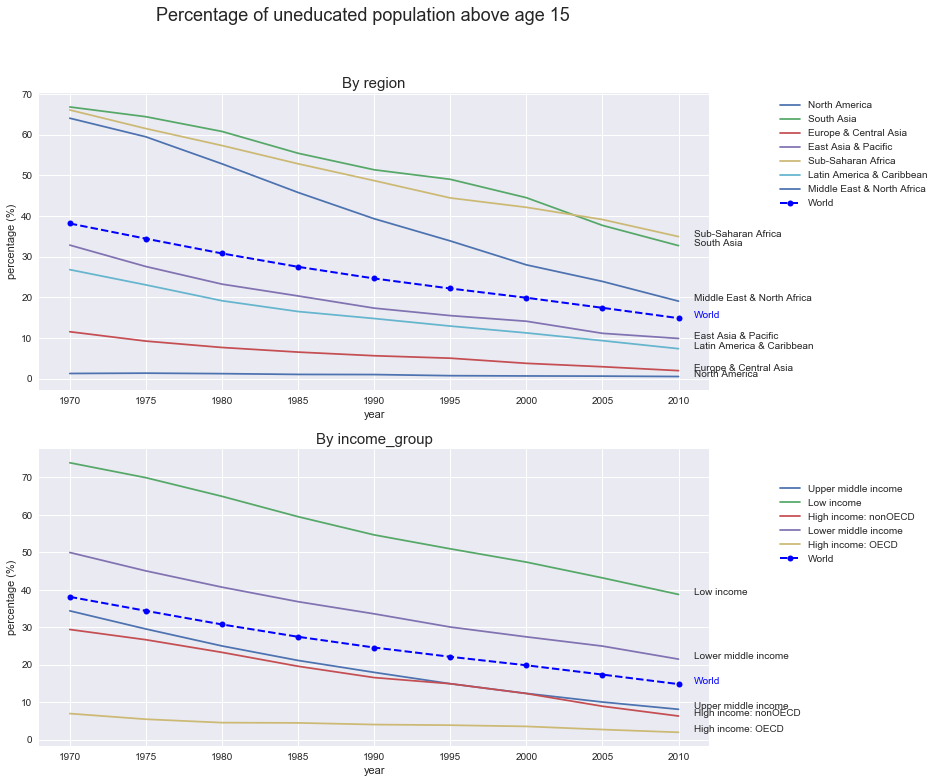

In [22]:
plt.figure(figsize=(12,12))
plt.suptitle('Percentage of uneducated population above age 15',fontsize = 18)

i = 1
for name,lst in {'region':regions,'income_group':income}.items():
    plt.subplot(2,1,i)
    plt.title('By {}'.format(name), fontsize = 15)
    df = per_noed.groupby([name,'year']).mean()
    for group in lst:
        plt.plot(df.loc[(group)])
        plt.annotate(group,xy=(2010+1,df.loc[(group)].loc[(2010)]))   
    plt.plot(world_noed,color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=6)
    plt.annotate('World',xy=(2010+1,world_noed.loc[(2010)]),color='blue')
    plt.ylabel('percentage (%)')
    plt.xlabel('year')
    plt.legend(lst+['World'],ncol=1, loc=(1.1,0.6))
    i+=1
    
plt.show()

Overall:
> As we can see from the graph, uneducation rate decreases gloablly and gradually from 1970 to 2010. The world average decreases from about 39% in 1970 to about 15% in 2010.

By region:
> 1. North American countries have the lowest uneducation rate throughout the period.
> 2. Middle East & North Africa has the highest decreaing rate.
> 3. South Asia surpasses Sub-Saharan Africa between 2000 and 2005.

By income group:
> 1. High income OECD countries have the lowest uneducation rates.
> 2. High income non OECD countries have similar uneducation rate as upper middle income countries.
> 3. On average, uneducation rate in low income countries is about 50% higher than high income OECD countries. 

We next obtain a more granular view of this indicator by drawing a **colorpleth map**. Since the differences between different country groups seem to be pretty consistent, we focuses on one year of data. We will look at 2010, since it is the most recent data.

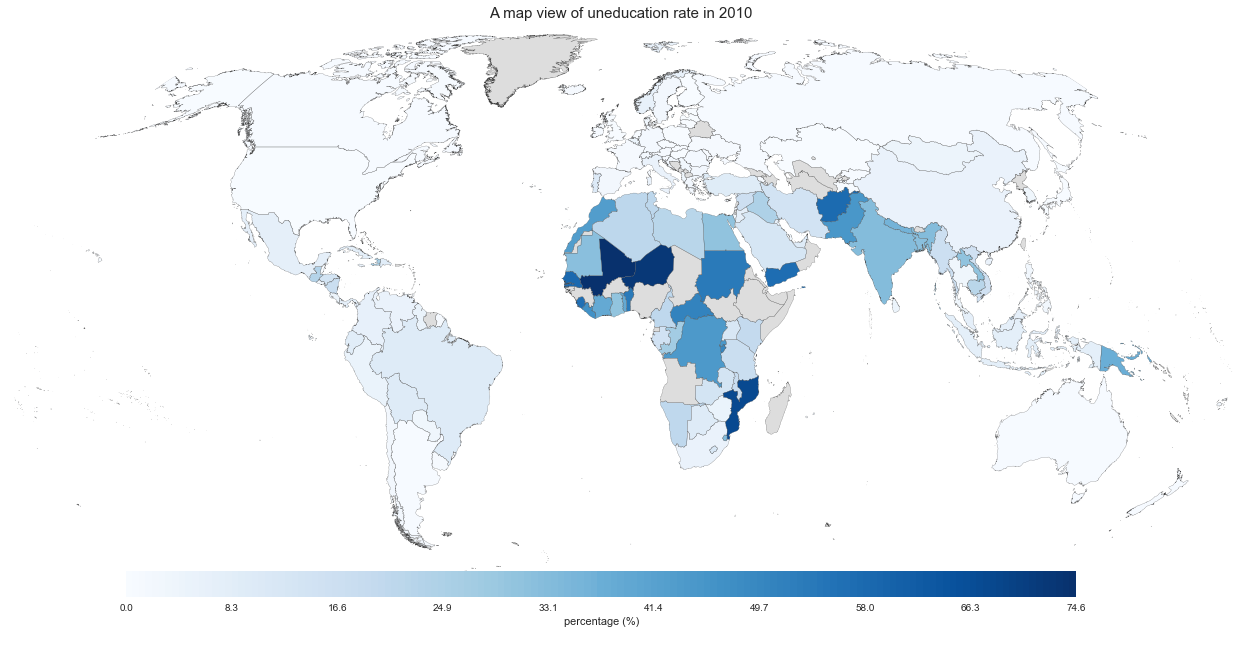

In [23]:
# subset 2010 data
geo_df = per_noed[per_noed['year'] == 2010][['country_code','value']]
v_min = geo_df['value'].min()
v_max = geo_df['value'].max()
num_colors = per_noed['country_code'].nunique()
bins = np.linspace(v_min, v_max, num_colors)
geo_df['bin'] = np.digitize(geo_df['value'], bins) - 1

# initialize basemap
cm = plt.get_cmap('Blues')
scheme = [cm(i / num_colors) for i in range(num_colors)]

fig = plt.figure(figsize=(22, 12))
ax = fig.add_subplot(111, facecolor = 'w', frame_on=False)
plt.title('A map view of uneducation rate in 2010', fontsize = 15)

m = Basemap(lon_0=0, projection='robin')
m.drawmapboundary(color='w')
shapefile = 'shapefiles/ne_10m_admin_0_countries'
m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)

# fill area with data
for info, shape in zip(m.units_info, m.units):
    country = info['ADM0_A3']
    try:
        color = scheme[int(geo_df[geo_df['country_code'] == country]['bin'])]
    except:
        color = '#dddddd'
    patches = [Polygon(np.array(shape), True)]
    pc = PatchCollection(patches)
    pc.set_facecolor(color)
    ax.add_collection(pc)
    
ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)
ax_legend = fig.add_axes([0.2, 0.2, 0.6, 0.03], zorder=3)
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=np.linspace(v_min, v_max, 10), 
                               boundaries=bins, orientation='horizontal')
cb.ax.set_xticklabels([str(round(i,1)) for i in np.linspace(v_min, v_max, 10)])
cb.set_label('percentage (%)')

plt.show()

> As shown in the colorpleth map, some countries in the Africa continent have the lowest uneducation rate above age 15 in 2010. In fact, as shown in the next figure, the top five countries that have the highest uneducation rate are from Sub-Saharan Africa, and 8 out of the top 10 are from the region, with Mali having the lowest rate of 74.6%. However, within Africa, we also see low uneducation rate in various countries, like Zimbabwe (5.1%) and South Africa (5.38%). This makes a difference of 69.5%, demonstrating the severity of education attainment disparity in Africa.

> Europe, North America, and Latin America seem to have really low uneducation rates. In fact, Lithuania, Finland and the Netherlands all have zero uneducation rate. Belize has the lowest uneducation rate in Latin America and it is lower than any countries from continents other than Europe. 

> West of South Asia also has high uneducation rate, with Afghanistan having the lowest rate of 58.38%. 

In [24]:
sort_2010 = per_noed[per_noed['year'] == 2010][['country_name','region','value']].sort_values('value', ascending = False)
sort_2010.head(10)

country_name                      region  value
80    Mali          Sub-Saharan Africa          74.57
627   Niger         Sub-Saharan Africa          72.85
608   Mozambique    Sub-Saharan Africa          68.14
374   Gambia, The   Sub-Saharan Africa          61.76
1020  Senegal       Sub-Saharan Africa          58.58
326   Afghanistan   South Asia                  58.38
501   Yemen, Rep.   Middle East & North Africa  57.49
1164  Sierra Leone  Sub-Saharan Africa          57.00
918   Benin         Sub-Saharan Africa          53.91
185   Sudan         Sub-Saharan Africa          53.74

In [25]:
sort_2010[sort_2010['region'] == 'Sub-Saharan Africa'].tail()

country_name              region  value
933   Uganda        Sub-Saharan Africa  12.18
698   Botswana      Sub-Saharan Africa  9.83 
367   South Africa  Sub-Saharan Africa  5.65 
982   Mauritius     Sub-Saharan Africa  5.38 
1017  Zimbabwe      Sub-Saharan Africa  5.08

In [26]:
sort_2010_asc = per_noed[per_noed['year'] == 2010][['country_name','region','value']].sort_values('value')
sort_2010_asc.head(10)

country_name                     region  value
976   Lithuania       Europe & Central Asia      0.00 
925   Finland         Europe & Central Asia      0.00 
842   Netherlands     Europe & Central Asia      0.00 
450   Kazakhstan      Europe & Central Asia      0.05 
441   Belize          Latin America & Caribbean  0.09 
1220  Japan           East Asia & Pacific        0.13 
1292  United Kingdom  Europe & Central Asia      0.15 
187   Czech Republic  Europe & Central Asia      0.15 
12    Estonia         Europe & Central Asia      0.20 
834   Barbados        Latin America & Caribbean  0.22

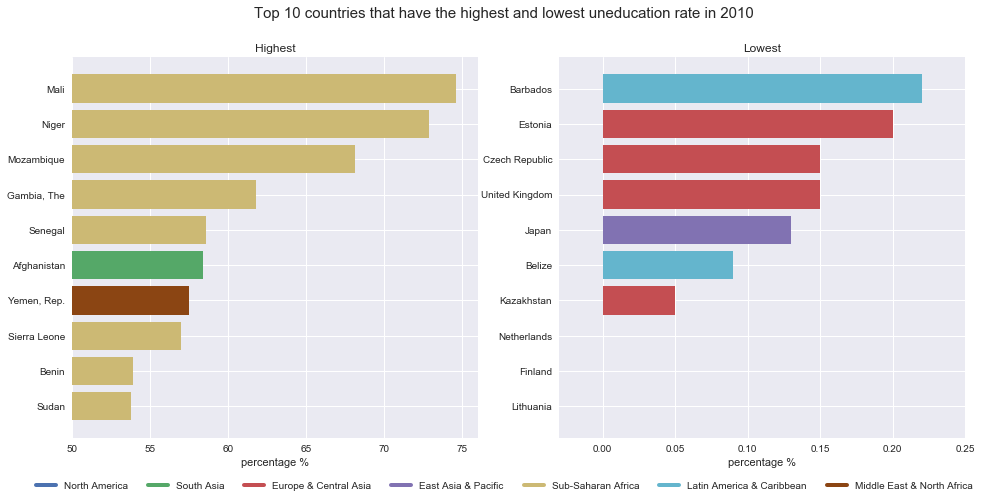

In [27]:
# set colors for different region
regions = list(set(per_noed['region']))
n_colors = len(regions)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"] + ['#8b4513']
colors = {regions[i]:colors[i] for i in range(n_colors)}

# make legend elements
legend_elements = [Line2D([0], [0], color=colors[region], lw=4, label='Line') for region in colors.keys()]

# start plotting
plt.figure(figsize = (16,7))
plt.suptitle('Top 10 countries that have the highest and lowest uneducation rate in 2010', fontsize =15)

plt.subplot(1,2,1)
plt.title('Highest')
bar = sort_2010.head(10)
for i in bar.index:
    plt.barh(bar.loc[i]['country_name'],bar.loc[i]['value'],color=colors[bar.loc[i]['region']])
plt.xlim(50,76)
plt.xlabel('percentage %')
plt.gca().invert_yaxis()
# add legend here 
plt.legend(handles = legend_elements, labels = colors.keys(), ncol = 7, loc = (-0.1,-0.15))

plt.subplot(1,2,2)
plt.title('Lowest')
bar = sort_2010_asc.head(10)
for i in bar.index:
    plt.barh(bar.loc[i]['country_name'],bar.loc[i]['value'],color=colors[bar.loc[i]['region']])
plt.xlabel('percentage %')
plt.xlim(-0.03,0.25)

plt.show()

> This is a bar chart visualizing the top 10 countries that have the highest and lowest uneducation rates. Colors of the bars corresponds to different regions. 

---
### II.ii Economics and Education

We then proceed to evaluate indicators of the Economic Policy & Debt topic.

In [28]:
econ_ind = indicators.loc[indicators['topic'] == 'Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators']
econ_ind

topic  \
3     Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators   
579   Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators   
2788  Economic Policy & Debt: National accounts: US$ at current prices: Aggregate indicators   

         series_code                indicator_name  counts  
3     NY.GDP.PCAP.CD  GDP per capita (current US$)  9196    
579   NY.GNP.MKTP.CD  GNI (current US$)             8800    
2788  NY.GDP.MKTP.CD  GDP (current US$)             9199

Specifically, we will look at GDP per capita (current US$) and its relationship with the education attatinment data we visualized above. 

In [29]:
econ_ind = 'NY.GDP.PCAP.CD' # GDP per capita (current US$)

Write query and check the size of the query.

In [30]:
my_job_config = bigquery.job.QueryJobConfig()
my_job_config.dry_run = True

query = query_format.format(international_education, country_summary, econ_ind)

my_job = client.query(query, job_config=my_job_config)
print('This query would take about',my_job.total_bytes_processed / 1048576,'MB')

This query would take about 245.18322849273682 MB


Write Google BigQuery job, retrieve results, convert them to dataframe, and pickle the dataframe object for future use. This block is only run once.

In [32]:
job = client.query(query)
econ_df = job.to_dataframe()

pickling_on = open("econ_df.pickle","wb")
pickle.dump(econ_df, pickling_on)
pickling_on.close()

Pickle off dataframe for all future data processing.

In [31]:
pickle_off = open("econ_df.pickle","rb")
econ_df = pickle.load(pickle_off)
econ_df.head()

country_code          country_name                      region  \
0  PLW          Palau                 East Asia & Pacific          
1  SYR          Syrian Arab Republic  Middle East & North Africa   
2  LBN          Lebanon               Middle East & North Africa   
3  OED          OECD members                                       
4  LCA          St. Lucia             Latin America & Caribbean    

          income_group  year         value  
0  Upper middle income  1995  5520.025503   
1  Lower middle income  1998  974.275192    
2  Upper middle income  2012  8922.896752   
3                       2004  29399.835438  
4  Upper middle income  1988  2744.947497

We will use an **animated bubble chart** to visualize the relationship. Here, we will use education rate (1-uneducation rate) to gain a more intuitive visualization. To make a more dynamic bubble chart, I also imported data about population size, imported from the [World Bank data bank website](https://data.worldbank.org/indicator/SP.POP.TOTL). 

In [32]:
econ_df = econ_df.rename(columns = {'value':'gdp_pc'})
econ_df = econ_df.dropna()

In [33]:
pop_df = pd.read_csv('world_pop.csv', header=2)

# we look at 1970 to 2010 with 5 years in between because we want to compare this with our education attainment data
years_int = list(np.arange(1970,2011,5))
years = [str(year) for year in years_int]

cols = ['Country Code'] + years
pop_df = pop_df[cols]
pop_df = pd.melt(pop_df, id_vars=['Country Code'], value_vars=years)
pop_df = pop_df.rename(columns={'Country Code':'country_code', 'variable':'year','value':'pop'})
pop_df['year'] = pop_df['year'].astype(int)
pop_df.head()

country_code  year         pop
0  ABW          1970  59063.0   
1  AFG          1970  11126123.0
2  AGO          1970  6776381.0 
3  ALB          1970  2135479.0 
4  AND          1970  24276.0

Prepare data for bubble chart

In [34]:
bubble_df = pd.merge(econ_df, pop_df, how='inner', on=['country_code','year'])

# add on percentage of population above age 15 with no education
per_noed1 = per_noed[['country_code','year','value']]
per_noed1 = per_noed1.rename(columns={'value':'per_noed'})
bubble_df = pd.merge(bubble_df, per_noed1, how='inner', on=['country_code','year'])

# subset countries that have data from 1970 to 2010 with step of 5 years
year_counts = bubble_df.groupby(['country_code'])['year'].count()
sub_countries = list(year_counts[year_counts == 9].index)
bubble_df = bubble_df[bubble_df['country_code'].isin(sub_countries)]

# calculate percentage of population above age 15 with education
bubble_df['per_ed'] = 100-bubble_df['per_noed']
bubble_df = bubble_df.drop(columns=['per_noed'])

print('There are',bubble_df['country_code'].nunique(),'countries that have three data from 1970 to 2010')
regions = list(set(bubble_df['region']))
print('They are from',regions, 'region.')

bubble_df.head()

There are 99 countries that have three data from 1970 to 2010
They are from ['North America', 'South Asia', 'Europe & Central Asia', 'East Asia & Pacific', 'Sub-Saharan Africa', 'Latin America & Caribbean', 'Middle East & North Africa'] region.


country_code country_name                      region  \
19   KWT          Kuwait       Middle East & North Africa   
46   KWT          Kuwait       Middle East & North Africa   
73   KWT          Kuwait       Middle East & North Africa   
103  KWT          Kuwait       Middle East & North Africa   
177  KWT          Kuwait       Middle East & North Africa   

             income_group  year        gdp_pc        pop  per_ed  
19   High income: nonOECD  2005  35490.261324  2276623.0  93.28   
46   High income: nonOECD  2010  38497.616958  2998083.0  93.91   
73   High income: nonOECD  1975  11731.553336  1024940.0  41.36   
103  High income: nonOECD  2000  18389.384328  2050741.0  76.80   
177  High income: nonOECD  1970  3848.569739   746767.0   55.16

We will use offline Plotly to generate our animated and interactive graph. 
- x axis represents education rate (the larger(righter) the better)
- y axis represents GDP per capita (in a log scale)
- each bubble represents a country
- size of the bubble represents the total population of the country
- color of the bubble represents the region the country is from
- the interactive slide allows user to look at the static view of the chart in one particular year
- the play button allows users to play the animation and see how the graph evolves from year 1970 to 2010
- the pause button allows users to stop the animation at anytime.


In [35]:
# offline plotly: connected to notebook
offline.init_notebook_mode()

# make figure
figure = {'data': [],'layout': {},'frames': []}

# fill in most of layout
figure['layout']['title'] = 'Bubble chart animation'
figure['layout']['xaxis'] = {'range': [0, 110], 'title': 'Percentage of population above age 15 that are educated'}
figure['layout']['yaxis'] = {'title': 'GDP per Capita', 'type': 'log'}
figure['layout']['hovermode'] = 'closest'

# add slider
figure['layout']['sliders'] = {'args': ['transition', {'duration': 450,'easing': 'cubic-in-out'}],
                               'initialValue': '1970','plotlycommand': 'animate','values': years,'visible': True}

sliders_dict = {'active': 0,'yanchor': 'top','xanchor': 'left','currentvalue': {'font': {'size': 20},
                                                                                'prefix': 'Year:',
                                                                                'visible': True,
                                                                                'xanchor': 'right'},
                'transition': {'duration': 450, 'easing': 'cubic-in-out'}, 'pad': {'b': 10, 't': 50},
                'len': 0.9, 'x': 0.1, 'y': 0, 'steps': []}

# add buttons for play and pause
figure['layout']['updatemenus'] = [{'buttons': [{'args': [None, {'frame': {'duration': 450, 'redraw': False},
                                                                 #'fromcurrent': True, 
                                                                 'transition': {'duration': 450, 'easing': 'quadratic-in-out'}}],
                                                 'label': 'Play','method': 'animate'},
                                                {'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                                                                   'transition': {'duration': 0}}],
                                                 'label': 'Pause','method': 'animate'}],
                                    'direction': 'left', 'pad': {'r': 10, 't': 87}, 'showactive': False,
                                    'type': 'buttons', 'x': 0.1, 'xanchor': 'right', 'y': 0, 'yanchor': 'top'}]

# make initial data
year = 1970
for group in regions:
    bubble_by_year = bubble_df[bubble_df['year'] == year]
    bubble_by_year_and_group = bubble_by_year[bubble_by_year['region'] == group]

    data_dict = {'x': list(bubble_by_year_and_group['per_ed']),
                 'y': list(bubble_by_year_and_group['gdp_pc']),
                 'mode': 'markers',
                 'text': list(bubble_by_year_and_group['country_name']),
                 'marker': {'sizemode': 'area','sizeref': 200000,'size': list(bubble_by_year_and_group['pop'])},
                 'name': group}
    figure['data'].append(data_dict)

# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for group in regions:
        bubble_by_year = bubble_df[bubble_df['year'] == int(year)]
        bubble_by_year_and_group = bubble_by_year[bubble_by_year['region'] == group]

        data_dict = {'x': list(bubble_by_year_and_group['per_ed']),
                     'y': list(bubble_by_year_and_group['gdp_pc']),
                     'mode': 'markers',
                     'text': list(bubble_by_year_and_group['country_name']),
                     'marker': {'sizemode': 'area','sizeref': 200000,'size': list(bubble_by_year_and_group['pop'])},
                     'name': group}
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [[year], {'frame': {'duration': 450, 'redraw': False},
                                     'mode': 'immediate',
                                     'transition': {'duration': 450}}],
                   'label': year,'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

# update slider
figure['layout']['sliders'] = [sliders_dict]

# plot
offline.iplot(figure)

> This dynamic graph clearly shows that many Sub-Saharan Africa countries are left behind over the 1970-2010 period. We can also see that education rates vary very much across the region. 

> Countries in East Asia & Pacific catch up the fastest in education rate, as well as their population sizes.

> Europe and North America have the highest education rate as well as GDP per Capita over the period. 

> There seems to be a linear relationship between GDP per Capita and education rate.

---
### II.iii Edcuation Expenditures

We next look into indicators in the Education Expenditures topic. 

In [36]:
exp_ind = indicators.loc[indicators['topic'] == 'Expenditures'].sort_values('counts',ascending = False)
exp_ind.head(10)

topic         series_code  \
2688  Expenditures  SE.XPD.TOTL.GD.ZS    
2326  Expenditures  SE.XPD.TERT.ZS       
1568  Expenditures  SE.XPD.PRIM.ZS       
912   Expenditures  SE.XPD.SECO.ZS       
1353  Expenditures  SE.XPD.TOTL.GB.ZS    
510   Expenditures  SE.XPD.PRIM.PC.ZS    
476   Expenditures  UIS.XGDP.56.FSGOV    
613   Expenditures  SE.XPD.TERT.PC.ZS    
1248  Expenditures  UIS.XGDP.1.FSGOV     
2918  Expenditures  UIS.XGOVEXP.IMF.56   

                                                                indicator_name  \
2688  Government expenditure on education as % of GDP (%)                        
2326  Expenditure on tertiary as % of government expenditure on education (%)    
1568  Expenditure on primary as % of government expenditure on education (%)     
912   Expenditure on secondary as % of government expenditure on education (%)   
1353  Expenditure on education as % of total government expenditure (%)          
510   Government expenditure per primary student as % of GDP per capita (%)      
476   Government expenditure on tertiary education as % of GDP (%)               
613   Government expenditure per tertiary student as % of GDP per capita (%)     
1248  Government expenditure on primary education as % of GDP (%)                
2918  Expenditure on tertiary as % of total government expenditure (%)           

      counts  
2688  3538    
2326  3158    
1568  2795    
912   2787    
1353  2425    
510   1496    
476   1408    
613   1367    
1248  1350    
2918  1342

The first five seem interesting. We will look at them all!

As usual, we first write the query and check 'how much' it would cost.

In [37]:
my_job_config = bigquery.job.QueryJobConfig()
my_job_config.dry_run = True

query = '''
SELECT 
    i.country_code,
    i.country_name,
    c.region,
    c.income_group,
    i.indicator_code,
    i.indicator_name,
    i.year,
    i.value
FROM 
    `{}` AS i
LEFT JOIN
    `{}` AS c
ON 
    i.country_code = c.country_code
WHERE
    i.indicator_code = 'SE.XPD.TOTL.GD.ZS'
OR
    i.indicator_code = 'SE.XPD.TERT.ZS'
OR
    i.indicator_code = 'SE.XPD.PRIM.ZS'
OR
    i.indicator_code = 'SE.XPD.SECO.ZS'
OR 
    i.indicator_code = 'SE.XPD.TOTL.GB.ZS';
'''.format(international_education, country_summary)

my_job = client.query(query, job_config=my_job_config)
print('This query would take about',my_job.total_bytes_processed / 1048576,'MB')

This query would take about 595.9361429214478 MB


It is still no where near 1T, so we will go ahead to retrieve results, convert them into a dataframe, and pickle the dataframe object. This cell is only run once.

In [48]:
job = client.query(query)
exp_df = job.to_dataframe()

pickling_on = open("exp_df.pickle","wb")
pickle.dump(exp_df, pickling_on)
pickling_on.close()

Pickle off the expenditures dataframe and take a sneak peak of the table.

In [38]:
pickle_off = open("exp_df.pickle","rb")
exp_df = pickle.load(pickle_off)
exp_df.head()

country_code  country_name                      region  \
0  SAU          Saudi Arabia  Middle East & North Africa   
1  GEO          Georgia       Europe & Central Asia        
2  ZWE          Zimbabwe      Sub-Saharan Africa           
3  SVN          Slovenia      Europe & Central Asia        
4  CUB          Cuba          Latin America & Caribbean    

           income_group     indicator_code  \
0  High income: nonOECD  SE.XPD.TERT.ZS      
1  Lower middle income   SE.XPD.PRIM.ZS      
2  Low income            SE.XPD.TOTL.GB.ZS   
3  High income: OECD     SE.XPD.TERT.ZS      
4  Upper middle income   SE.XPD.PRIM.ZS      

                                                            indicator_name  \
0  Expenditure on tertiary as % of government expenditure on education (%)   
1  Expenditure on primary as % of government expenditure on education (%)    
2  Expenditure on education as % of total government expenditure (%)         
3  Expenditure on tertiary as % of government expenditure on education (%)   
4  Expenditure on primary as % of government expenditure on education (%)    

   year      value  
0  1993  20.928570  
1  2011  31.244770  
2  2012  29.199209  
3  2002  22.056219  
4  2001  31.159790

We will first visualize **the breakdown of governement expenditures on education**, by primary education, secondary education, and tertiary education.

Prepare dataframe for visualization

In [39]:
exp_prim = exp_df[exp_df['indicator_code'] == 'SE.XPD.PRIM.ZS'].drop(columns=['indicator_name','indicator_code'])
exp_prim = exp_prim.rename(columns={'value':'primary'})
exp_sec = exp_df[exp_df['indicator_code'] == 'SE.XPD.SECO.ZS'][['country_code','year','value']]
exp_sec = exp_sec.rename(columns={'value':'secondary'})
exp_tert = exp_df[exp_df['indicator_code'] == 'SE.XPD.TERT.ZS'][['country_code','year','value']]
exp_tert = exp_tert.rename(columns={'value':'tertiary'})

# we use outer join have a first visualization of the data without subseting the data
exp_bd = pd.merge(exp_prim, exp_sec, how='outer', on= ['country_code','year'])
exp_bd = pd.merge(exp_bd, exp_tert, how='outer', on= ['country_code','year'])
exp_bd.head()

country_code              country_name                     region  \
0  GEO          Georgia                   Europe & Central Asia       
1  CUB          Cuba                      Latin America & Caribbean   
2  CAF          Central African Republic  Sub-Saharan Africa          
3  SLE          Sierra Leone              Sub-Saharan Africa          
4  PNG          Papua New Guinea          East Asia & Pacific         

          income_group  year    primary  secondary   tertiary  
0  Lower middle income  2011  31.244770  29.044189  11.160400  
1  Upper middle income  2001  31.159790  36.390671  17.104811  
2  Low income           2006  52.456741  23.716110  22.818541  
3  Low income           2009  48.890049  28.349710  19.758141  
4  Lower middle income  1977  30.070110  21.663490  40.426540

Initial explorative visualization of trends by region

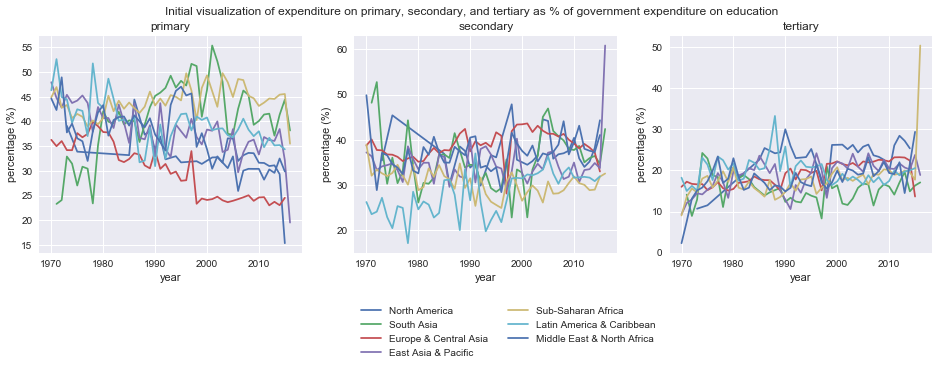

In [40]:
exp_bd_region = exp_bd.groupby(['region','year']).mean()
regions = list(set(exp_bd_region.index.get_level_values(0)))[1:]
levels = ['primary','secondary','tertiary']

plt.figure(figsize = (16, 4))
plt.suptitle('Initial visualization of expenditure on primary, secondary, and tertiary as % of government expenditure on education')

i = 1
for level in levels:
    plt.subplot(1,3,i)
    plt.title(level)
    for region in regions:
        plt.plot(exp_bd_region.loc[(region)][level])
    plt.xlabel('year')
    plt.ylabel('percentage (%)')
    if i == 2:
        plt.legend(regions, ncol=2, loc=(0.01,-0.5))
    i+=1

plt.show()

> All three graphs fluctuate a lot. 

> Looking at these graphs, one might even conclude that all regions are decreasing percentage of spending on primary education, that Sub_Saharan Africa is increasing secondary education drastically after 2015, or that East Asia & Pacific is increasing tertiary education drastically after 2015. 

> However, as we will see bellow, data for these three indicators are very inconsistent, meaning that for each country, we don't have the same number of data points available, even if the number of datapoints are the same, they might correspond to different time period. This demonstrates the third challenge listed in the introduction section.

Before we can jump into any conclusion, we need to process the data first and get a consistent subset of data.

In [41]:
# subset years that have more than 90 countries' data avaliable 
threshold = 90 
year_counts = exp_bd.groupby(['year'])['primary','secondary','tertiary'].count()
for level in levels:
    year_counts = year_counts[year_counts[level] > threshold]
period = list(year_counts.index)
print('Year', period, 'has data for more than {} countries.'.format(threshold))
exp_bd = exp_bd[exp_bd['year'].isin(period)]

# subset countries with data during the selected period
country_counts = exp_bd.groupby(['country_name'])['primary','secondary','tertiary'].count()
for level in levels:
    country_counts = country_counts[country_counts[level] == len(period)]
lst = list(country_counts.index)
print('There are', len(lst), 'countries that have data for the chosen period.')
exp_bd = exp_bd[exp_bd['country_name'].isin(lst)]

Year [2009, 2010, 2011, 2012, 2013] has data for more than 90 countries.
There are 53 countries that have data for the chosen period.


Now that we have made sure that our data for the three indicators is consistent, we can proceed with visualization again.

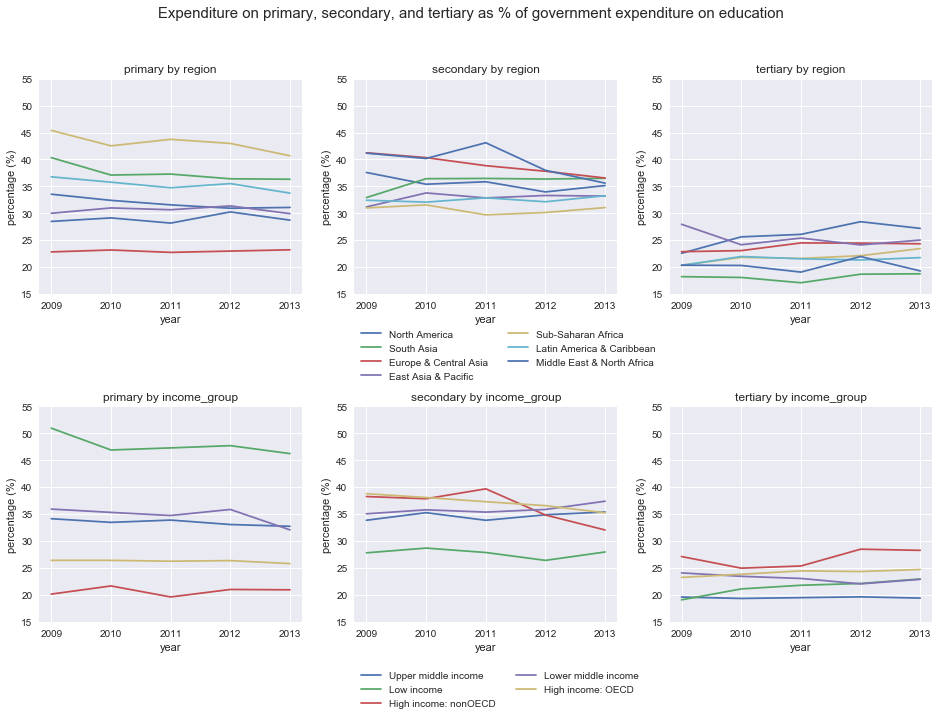

In [42]:
exp_bd_region = exp_bd.groupby(['region','year'])['primary','secondary','tertiary'].mean()
exp_bd_income = exp_bd.groupby(['income_group','year'])['primary','secondary','tertiary'].mean()
regions = list(set(exp_bd_region.index.get_level_values(0)))
income = list(set(exp_bd_income.index.get_level_values(0)))

plt.figure(figsize = (16, 10))
plt.suptitle('Expenditure on primary, secondary, and tertiary as % of government expenditure on education', fontsize =15)

i = 1
for name, lst in {'region':regions,'income_group':income}.items():
    for level in levels:
        plt.subplot(2,3,i)
        plt.title(level+' by {}'.format(name))
        if name == 'region': df = exp_bd_region
        else: df = exp_bd_income
        for group in lst:
            plt.plot(df.loc[(group)][level])
        plt.xlabel('year')
        plt.ylabel('percentage (%)')
        # standardize y range to compare the spread the level of data
        plt.ylim(15,55)
        if i == 2:
            plt.legend(regions, ncol=2, loc=(0.01,-0.42))
        if i == 5:
            plt.legend(income, ncol=2, loc=(0.01,-0.42))
        
        i+=1
plt.subplots_adjust(hspace=0.52)
plt.show()

Overall:
> As we can see, percentage on primary education varies the most among different country groups. This might be due to the fact that different country groups have different basic education systems. In some countries, primary schooling is heavily subsidized or free for its citizens, whereas in some countries, primary schooling is a personal investment for inidviual family. This might also be due to the fact that some countries only have limited capacity to focus on early schooling but not higher education.

> All country groups spend the least on tertiary education. This might be because higher education is normally not mandatory nor provided by national governments. Many universities are supported by private funding. This might also be because some countries don't have the financial capacity to fund higher education.

By region:
> Sub-Saharan Africa invests the highest percentage of their government education expenditures on the primary school level, decreases on the secondary level, and further decreases on the tertiary level. This is different than all other regions, which seems to invest more on secondary schools. This might be because countries in Sub-Saharan Africa lack sufficient financial capacity to invest in education after primary schooling. 

> Europe focuses the least on primary education compared to other regions. The lion share of its education expenditures goes to secondary education. This might be because in many European countries, such as Finland, [children don't start school until they are older](https://www.theguardian.com/education/2016/sep/20/grammar-schools-play-europe-top-education-system-finland-daycare). Daycare and home schooling is more prevalent for children in primary school ages. 

By income group:
> Low income countries show a high focus on primary school. They show a similar pattern as the Sub-Saharan African countries. This shows that many Sub-Saharan African countries belong to low income country group, and further validates the explanation that low income countries might lack the financial capacity to support schools above primary school level. 

> Simiarly, high income countries show a weaker focus on primary schooling but a stronger focus on secondary schooling. This might be because in high income countries, children don't start school until they are older, since their families have the intellecture capacity to home school or the finanical ability to provide high quality daycare and private teachers. At the same time, universities attract more private funding from successful alumi.


However, these conclusions are preliminary. Because of the lack of data, we are only able to observe trends for a small portion of the world. We next take a closer look into the number of countries that have data available in each country group.

In [43]:
region_counts = (exp_bd.groupby(['region'])['country_name'].count()/len(period)).astype('int32')
print(region_counts)
income_counts = (exp_bd.groupby(['income_group'])['country_name'].count()/len(period)).astype('int32')
print('\n',income_counts)

region
East Asia & Pacific           8 
Europe & Central Asia         15
Latin America & Caribbean     10
Middle East & North Africa    3 
North America                 1 
South Asia                    4 
Sub-Saharan Africa            12
Name: country_name, dtype: int32

 income_group
High income: OECD       17
High income: nonOECD    5 
Low income              9 
Lower middle income     8 
Upper middle income     14
Name: country_name, dtype: int32


At our first glance, the number of countries by region appears to be unbalanced. However, before we can jump into any conclusion, we should compare to the total numbers of countries within each region based on the World Bank's country classfication. The information is available on the [World Bank's website](https://datahelpdesk.worldbank.org/knowledgebase/articles/906519 ) and we will webscrap the number of countries for each region and income group using request and BeautifulSoup.


In [44]:
url = 'https://datahelpdesk.worldbank.org/knowledgebase/articles/906519'
page = requests.get(url)
print(page.status_code)
soup = BeautifulSoup(page.content, 'html.parser')

200


Status quote shows request is successful

In [45]:
name_box = soup.find_all('b')
names = [name.text for name in name_box]
names = list(filter(lambda s: re.match("[^a-z]+\s", s), names))
names = [s.strip() for s in names]
n_box = soup.find_all('p')
n = [line.text for line in n_box]
n_list = list(filter(lambda s: re.match('\(\d+\)',s),n))

n_list = [s.strip() for s in n_list]
n_list = [int(s.replace('(','').replace(')','')) for s in n_list]

group_counts = {name:n for name,n in zip(names,n_list)}
group_counts

{'EAST ASIA AND PACIFIC': 38,
 'EUROPE AND CENTRAL ASIA': 58,
 'LATIN AMERICA AND THE CARIBBEAN': 42,
 'MIDDLE EAST AND NORTH\nAFRICA': 21,
 'NORTH AMERICA': 3,
 'SOUTH ASIA': 8,
 'SUB-SAHARAN AFRICA': 48,
 'LOW-INCOME ECONOMIES\n($995 OR LESS)': 34,
 'LOWER-MIDDLE-INCOME\nECONOMIES ($996 TO $3,895)': 47,
 'UPPER-MIDDLE-INCOME\nECONOMIES ($3,896 TO $12,055)': 56,
 'HIGH-INCOME ECONOMIES\n($12,056 OR MORE)': 81}

In [46]:
exp_bd[exp_bd['region'] == 'North America']['country_name']

2721    United States
2725    United States
2726    United States
2728    United States
2732    United States
Name: country_name, dtype: object

In [47]:
df = pd.DataFrame(region_counts)
df['total'] = [group_counts[region] for region in list(group_counts.keys())[:-4]]
df['percentage'] = df['country_name']/df['total']
df

country_name  total  percentage
region                                                     
East Asia & Pacific         8             38     0.210526  
Europe & Central Asia       15            58     0.258621  
Latin America & Caribbean   10            42     0.238095  
Middle East & North Africa  3             21     0.142857  
North America               1             3      0.333333  
South Asia                  4             8      0.500000  
Sub-Saharan Africa          12            48     0.250000

> We can see that even though there is only one country representing North America in our dataset (the US), it actually represents 33% of the region, since there are only three countries grouped into the region. Even though Europe & Central Asia has 15 countries' data available, they only represent 26% of the region, since there are 58 countries in the region.

> Overall, we can see that the result we get only represents less than one third of the world. 

We proceed to visualize **aggregated government expenditures on education**. In specific, we will evaluation government expenditures on education as % of GDP and % of total government expenditures.

In [48]:
exp_gdp = exp_df[exp_df['indicator_code'] == 'SE.XPD.TOTL.GD.ZS'].drop(columns=['indicator_name','indicator_code'])
exp_gdp = exp_gdp.rename(columns = {'value':'% of gdp'})
exp_gov = exp_df[exp_df['indicator_code'] == 'SE.XPD.TOTL.GB.ZS'][['country_code','year','value']]
exp_gov = exp_gov.rename(columns = {'value':'% of gov expenditures'})

exp_agg = pd.merge(exp_gdp, exp_gov, how='outer', on= ['country_code','year'])
exp_agg = exp_agg.dropna()
exp_agg.head()

country_code              country_name                     region  \
0  MRT          Mauritania                Sub-Saharan Africa          
1  SRB          Serbia                    Europe & Central Asia       
2  ATG          Antigua and Barbuda       Latin America & Caribbean   
3  KNA          St. Kitts and Nevis       Latin America & Caribbean   
4  CAF          Central African Republic  Sub-Saharan Africa          

           income_group  year  % of gdp  % of gov expenditures  
0  Lower middle income   2013  2.93012   11.40537               
1  Upper middle income   2010  4.58238   10.51355               
2  High income: nonOECD  1999  3.23707   12.52143               
3  High income: nonOECD  1987  2.77332   13.00741               
4  Low income            1990  2.24566   11.14008

To avoid inconsistent data, we will first process the data like we did above.

In [49]:
# subset years with more data
inds = ['% of gdp','% of gov expenditures']
year_counts = exp_agg.groupby(['year'])['% of gdp','% of gov expenditures'].count()
threshold = 100 
for ind in inds:
    year_counts = year_counts[year_counts[ind] > threshold]
period = list(year_counts.index)
print('Year', period, 'has data for more than {} countries.'.format(threshold))
exp_agg = exp_agg[exp_agg['year'].isin(period)]

# subset countries with data during the selected period
country_counts = exp_agg.groupby(['country_name'])['% of gdp','% of gov expenditures'].count()
for ind in inds:
    country_counts = country_counts[country_counts[ind] == len(period)]
lst = list(country_counts.index)
print('There are', len(lst), 'countries that have data for the chosen period.')
exp_agg = exp_agg[exp_agg['country_name'].isin(lst)]

Year [1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013] has data for more than 100 countries.
There are 26 countries that have data for the chosen period.


The below lists the 26 countries by both country groupings:

In [50]:
print(exp_agg.groupby(['region','country_name'])['year'].count()/len(period))
print(exp_agg.groupby(['income_group','country_name'])['year'].count()/len(period))

region                      country_name      
East Asia & Pacific         Thailand              1.0
Europe & Central Asia       Austria               1.0
                            Azerbaijan            1.0
                            Czech Republic        1.0
                            Denmark               1.0
                            Finland               1.0
                            France                1.0
                            Iceland               1.0
                            Ireland               1.0
                            Kyrgyz Republic       1.0
                            Netherlands           1.0
                            Norway                1.0
                            Poland                1.0
                            Portugal              1.0
                            Slovak Republic       1.0
                            Spain                 1.0
                            Sweden                1.0
                            Switzer

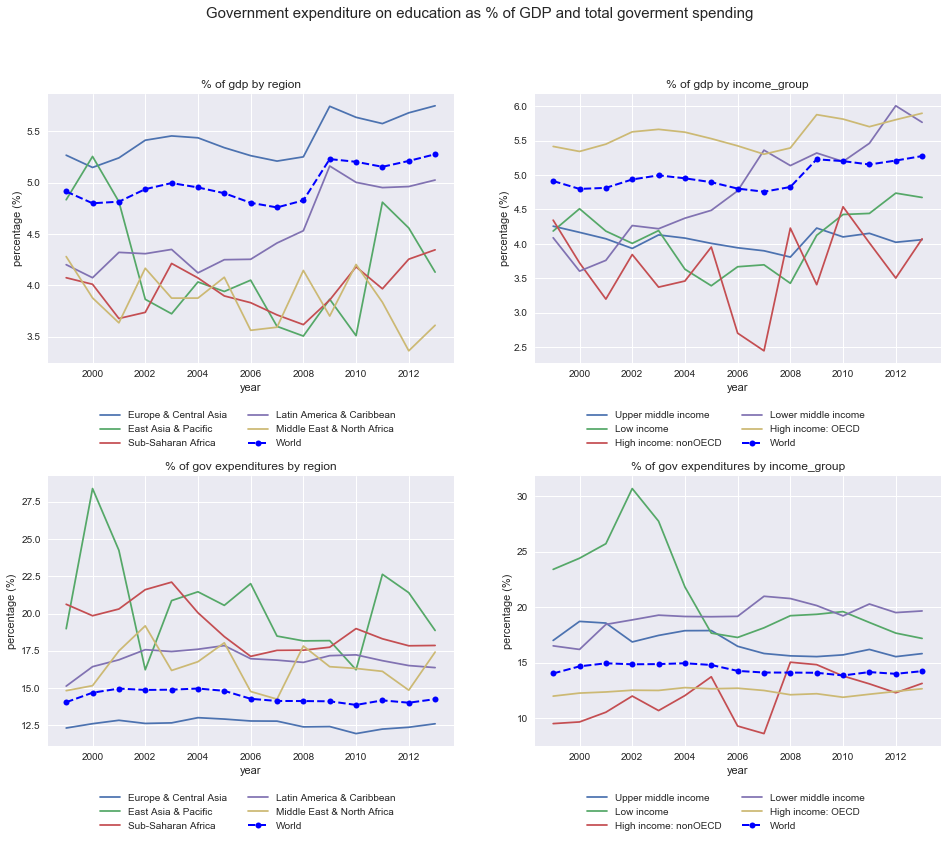

In [51]:
world_agg = exp_agg.groupby(['year']).mean()
regions = list(set(exp_agg['region']))
income = list(set(exp_agg['income_group']))

plt.figure(figsize=(16,12))
plt.suptitle('Government expenditure on education as % of GDP and total goverment spending', fontsize = 15)

i = 1
for ind in inds:
    for name,lst in {'region':regions,'income_group':income}.items():
        plt.subplot(2,2,i)
        plt.title('{} by {}'.format(ind,name))
        df = exp_agg.groupby([name,'year']).mean()
        for group in lst:
            plt.plot(df.loc[(group)][ind])
        plt.plot(world_agg[ind],color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=6)
        plt.ylabel('percentage (%)')
        plt.xlabel('year')
        plt.legend(lst+['World'],ncol=2, loc=(0.12,-0.33))
        i+=1
plt.subplots_adjust(hspace=0.42)
plt.show()

> Line charts for both indicators flucturate quite a lot. This might be partially due to the fact that we only have 26 countries' data available. The lines (mean of countries within that country group) would be smoother if we have more data available. 

Just by looking at the graphs available, we can see that overall:

> There is a noticeable increase of world average from 2008 to 2009 in % of GDP, but not in % of total government expenditures. This might be because many countries' GDP suffered during the global financial crisis. 

> For % of GDP, only European and Central Asian and high income OECD countries beat the world's average througout the period. However, it is the opposite if we look at % of total government spending. This interesting result might be because the proportion of government spending of GDP is higher for these countries. That is, if we consider the following as the [formula for GDP](https://courses.lumenlearning.com/boundless-economics/chapter/comparing-real-and-nominal-gdp/): private consumption + gross investment + government investment + government spending + (exports – imports), these countries' government spendings have a higher influence on GDP than the averages of other country groups. To gain a better understanding of this result, it is necessary to look at the breakdown of GDP of different countries. For the purpose of the report, we will not get into it here.

---
### II.iv Learning Outcomes

Lastly, we will look at three indicators from Learning Outcomes--mean performance on Science, Reading, and Math scores, provided by the OECD Programme for International Student Assessment (PISA). Note that the three indicators are manually selected. Even though indicators from the topic Learning Outcomes don't have over 1000 datapoints, they are valuable for visualizing the level of education in countries where data is available. 

As usual, first write and check the size of the query.

In [52]:
my_job_config = bigquery.job.QueryJobConfig()
my_job_config.dry_run = True

query = '''
SELECT 
    i.country_code,
    i.country_name,
    c.region,
    c.income_group,
    i.indicator_code,
    i.indicator_name,
    i.year,
    i.value
FROM 
    `{}` AS i
LEFT JOIN
    `{}` AS c
ON 
    i.country_code = c.country_code
WHERE
    i.indicator_code = 'LO.PISA.SCI'
OR
    i.indicator_code = 'LO.PISA.REA'
OR
    i.indicator_code = 'LO.PISA.MAT';
'''.format(international_education, country_summary)

my_job = client.query(query, job_config=my_job_config)
print('This query would take about',my_job.total_bytes_processed / 1048576,'MB')

This query would take about 595.9361429214478 MB


We are still far away from the 1T quota. Go ahead and get data! This cell is only run once.

In [69]:
job = client.query(query)
lo_df = job.to_dataframe()

pickling_on = open("lo_df.pickle","wb")
pickle.dump(lo_df, pickling_on)
pickling_on.close()

Pickle off the resulting dataframe for all future processing. 

In [53]:
pickle_off = open("lo_df.pickle","rb")
lo_df = pickle.load(pickle_off)
lo_df.head()

country_code   country_name                 region          income_group  \
0  USA          United States  North America          High income: OECD      
1  LIE          Liechtenstein  Europe & Central Asia  High income: nonOECD   
2  HRV          Croatia        Europe & Central Asia  High income: nonOECD   
3  EST          Estonia        Europe & Central Asia  High income: OECD      
4  LIE          Liechtenstein  Europe & Central Asia  High income: nonOECD   

  indicator_code                                   indicator_name  year  \
0  LO.PISA.MAT    PISA: Mean performance on the mathematics scale  2009   
1  LO.PISA.SCI    PISA: Mean performance on the science scale      2012   
2  LO.PISA.MAT    PISA: Mean performance on the mathematics scale  2006   
3  LO.PISA.REA    PISA: Mean performance on the reading scale      2015   
4  LO.PISA.MAT    PISA: Mean performance on the mathematics scale  2012   

        value  
0  487.396520  
1  524.694992  
2  467.246714  
3  519.142900  
4  534.965083

In [54]:
lo_sci = lo_df[lo_df['indicator_code'] == 'LO.PISA.SCI'].drop(columns=['indicator_name','indicator_code'])
lo_sci = lo_sci.rename(columns={'value':'science'})
lo_rea = lo_df[lo_df['indicator_code'] == 'LO.PISA.REA'][['country_code','year','value']]
lo_rea = lo_rea.rename(columns={'value':'reading'})
lo_math = lo_df[lo_df['indicator_code'] == 'LO.PISA.MAT'][['country_code','year','value']]
lo_math = lo_math.rename(columns={'value':'math'})

lo_df = pd.merge(lo_sci, lo_rea, how='outer', on= ['country_code','year'])
lo_df = pd.merge(lo_df, lo_math, how='outer', on= ['country_code','year'])
lo_df.head()

country_code        country_name                 region  \
0  LIE          Liechtenstein       Europe & Central Asia   
1  TUR          Turkey              Europe & Central Asia   
2  POL          Poland              Europe & Central Asia   
3  RUS          Russian Federation  Europe & Central Asia   
4  CZE          Czech Republic      Europe & Central Asia   

           income_group  year     science     reading        math  
0  High income: nonOECD  2012  524.694992  515.521654  534.965083  
1  Upper middle income   2015  425.489500  428.335100  420.454000  
2  High income: OECD     2009  508.068298  500.478483  494.802919  
3  High income: nonOECD  2000  460.313938  461.762033  478.000000  
4  High income: OECD     2015  492.830000  487.250100  492.325400

As we can see below, we have data for every 3 years from 2000 to 2015, and the number of datapoints is quite consistent for each year and region.

In [55]:
print(lo_df.groupby(['year'])['science', 'reading', 'math'].count())
print(lo_df.groupby(['region'])['science', 'reading', 'math'].count())

      science  reading  math
year                        
2000  42       42       42  
2003  41       41       41  
2006  56       55       56  
2009  70       70       69  
2012  64       64       62  
2015  71       71       71  
                            science  reading  math
region                                            
East Asia & Pacific         58       58       58  
Europe & Central Asia       206      206      205 
Latin America & Caribbean   42       42       42  
Middle East & North Africa  25       25       23  
North America               12       11       12  
Sub-Saharan Africa          1        1        1   


We will first get a sense of the trend of scores by different country groups.

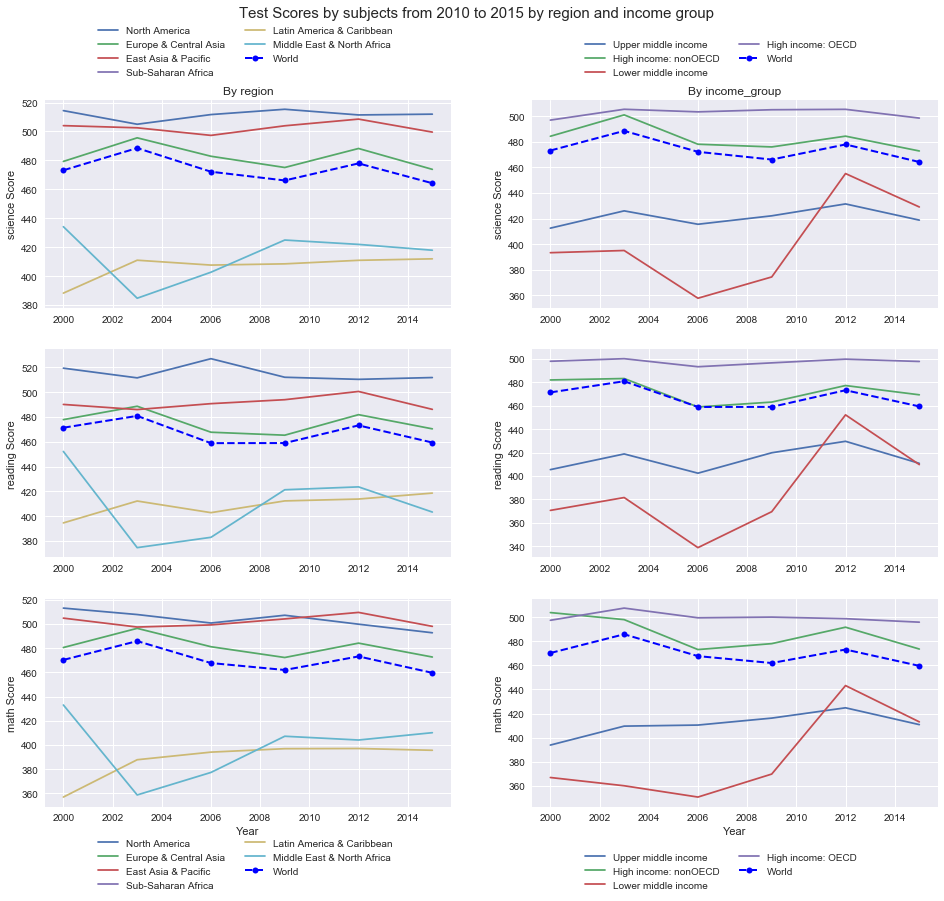

In [56]:
subjects = ['science', 'reading', 'math']

plt.figure(figsize = (16,13))
plt.suptitle('Test Scores by subjects from 2010 to 2015 by region and income group', fontsize = 15)

i = 1 
for subject in subjects:
    for name in ['region','income_group']:
        df = lo_df.groupby([name,'year'])[subject].mean()
        world = lo_df.groupby(['year'])[subject].mean()
        groups = list(set(lo_df[name]))
        plt.subplot(3,2,i)
        for group in groups:
            plt.plot(df.loc[(group)])
        plt.plot(world,color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=6)
        if i < 3:
            plt.title('By ' + name)
            plt.legend(groups+['World'], ncol = 2, loc = (0.12,1.09))
        if i > 4:
            plt.xlabel('Year')
            # add legend in both the top and the bottom of the graph is help readers read the graph
            plt.legend(groups+['World'], ncol = 2, loc = (0.12,-0.42))
        plt.ylabel(subject + ' Score')   
        i +=1
plt.show()

> From these line charts, we can easily divide the country groups into those above the world average and those below: North America, East Asia & Pacific, and Europe & Central Asia are consistently above the world average for all three subjects, while Middle East & North Africa and Latin America & Caribbean are consistenty below the world average. Similarly, high income OECD and non OECD countries are consistently above the world average, while upper middle income and lower middle income countries score are below the world average for all three subjects.

By subjects:
> North American countries outperform the rest of the world in reading and science throughout the period, and math until 2010 when East Asian students surpass their peers in North America. High income OECD countries maintain their best scores for all subject throughout from 2003 to 2015. 

> Countries in Middle East & North Africa and lower middle income countries show large fluctuations of performances throughout the period. Middle Eastern & North Afrian countries first experience a drastic drop from 2000 to 2003 and gradually increase from 2003 to 2009. Lower middle income countries have their lowest performance in 2006 for all subjects and drastically increase over the years until 2012 when all scores drop again.

> The world average of all three subjects shows a decreasing trend at the end of 2015. This should alarm teachers and educators worldwide. It is important to identify the reasons behind the drop of learning outcomes. However, it is also important to note that scores are not the only indicator for educational quality and learning outcomes. Students might have been building capacity in other important areas, such as creative thinking and programming, without improving their test scores in traditional subjects like reading, science and math. 

We will proceed to get a more granular view of the data by creating an **interactive graph** using ipywidgets interact. I created one dropdown menu and two sliders:
- dropdown menu: choices of three subjects
- 1st slider: choices of years from 2000 to 2015 (every three years)
- 2nd slider: the number of top performing countries

The graph is consisted of two subplots, one showing the top performing countries and their chosen subject scores (ordered) in the chosen year, and another showing the composition of countries in the top in terms of regions.

For instance, one state of the graph below shows the top 30 performing countries and their scores in math in 2015, as well as the composition of countries in terms of regions. 

In [57]:
# set colors for different region
regions = list(set(lo_df['region']))
n_colors = len(regions)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
colors = {regions[i]:colors[i] for i in range(n_colors)}

# make legend elements
legend_elements = [Line2D([0], [0], color=colors[region], lw=4, label='Line') for region in colors.keys()]

In [58]:
@interact(subject=['science','reading','math'], year=(2000,2015,3), n_countries=(5,30,5))
def plot_fun(subject,year,n_countries):
    subject = subject 
    year = year
    n_top = n_countries

    plt.figure(figsize=(12,7))
    plt.suptitle('Interactive plots on top performing countries', fontsize=15)

    # bar chart
    plt.subplot(1,2,1)
    bar = lo_df[lo_df['year'] == year].sort_values(subject, ascending = False).head(n_top)
    for i in bar.index:
        plt.barh(bar.loc[i]['country_name'],bar.loc[i][subject],color=colors[bar.loc[i]['region']])
    plt.xlim(bar[subject].min()-3,bar[subject].max()+3)
    plt.gca().invert_yaxis()

    # pie chart
    plt.subplot(1,2,2)
    pie = bar.groupby(['region'])[subject].count()
    plt.pie(pie, colors = [colors[region] for region in list(pie.index)], labels = list(pie.index), autopct='%1.1f%%')
    plt.legend(handles = legend_elements, labels = colors.keys(), loc = (1,-0.12))
    my_circle=plt.Circle((0,0), 0.7, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)

    plt.show()

interactive(children=(Dropdown(description='subject', options=('science', 'reading', 'math'), value='science')…

> **NOTE**: This graph is interactive but nbviewer can only display the dynamic widgets and a static state of the graph at the moment. To interact with the graph, please open the file with jupyter notebook, run the first code chunk to import packages, and run the codes in this section starting from pickling off the learning outcome dataframe. 

> Europe & Central Asia, East Asia & Pacific, and North America occupies the top 30 for all subjects from 2000 to 2015.

> Europe & Central Asia has the highest percentage of countries in top 30 for all subjects from 2000 to 2015. 

> East Asia & Pacific has the highest percentage of countries in top 10 for math and science from 2000 to 2015.

> However, these observations do not take into account of the number of countries in each region. Even though Europe & Central Asia has more countries in the top 30 for all subjects, it does not necessarily mean that more countries in the region belong to the top 30 than those who are not. 

For example, for 2015:

In [59]:
lo2015_df = lo_df[lo_df['year'] == 2015]
region_counts = lo2015_df.groupby(['region'])['country_code'].count()
region_counts = pd.DataFrame(region_counts).rename(columns = {'country_code':'total'})

for subject in ['science','reading','math']:
    df = lo2015_df.sort_values(subject, ascending = False).head(30)
    df = df.groupby(['region'])['country_code'].count()
    df = pd.DataFrame(df).rename(columns = {'country_code':subject})
    region_counts = region_counts.merge(df, how='left',left_index=True,right_index=True)

# we will only look at regions that have countries in the top 30
region_counts = region_counts.dropna(0)
region_counts

total  science  reading  math
region                                              
East Asia & Pacific    12     9.0      8.0      9.0 
Europe & Central Asia  39     19.0     20.0     20.0
North America          2      2.0      2.0      1.0

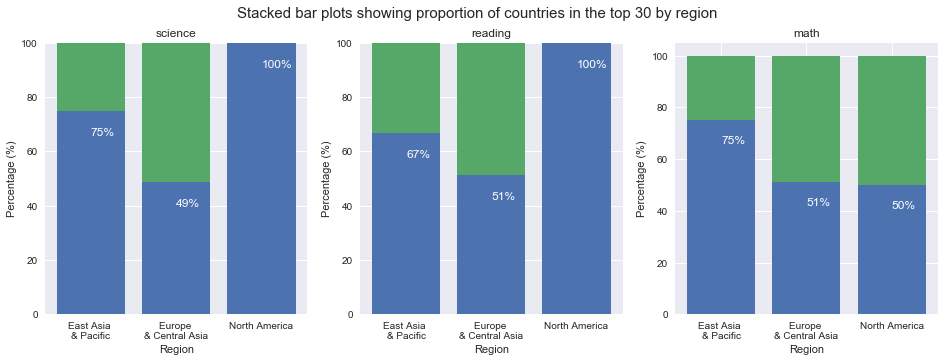

In [60]:
plt.figure(figsize = (16,5))
plt.suptitle('Stacked bar plots showing proportion of countries in the top 30 by region', fontsize=15)

xticks = list(region_counts.index)
xticks[0] = 'East Asia \n& Pacific'
xticks[1] = 'Europe \n& Central Asia'

i = 1 
for subject in ['science','reading','math']:
    plt.subplot(1,3,i)
    plt.title(subject)
    pct = region_counts[subject]/region_counts['total']*100
    ax = plt.bar(xticks, pct)
    for k,rect in enumerate(ax.patches):
        plt.annotate('{0:.0f}%'.format(pct[k]),xy=(xticks[k], rect.get_height()-9),color='w',fontsize=12)
    plt.bar(xticks, 100-pct, bottom = pct)
    plt.xlabel('Region')
    plt.ylabel('Percentage (%)')
    i+=1
plt.show()

> We see that even though Europe outperforms East Asia and North America with the number of countries in the top 30 countries. It underperforms when we look at the percentage of European countries in the top 30.

---
## III. Binary Classification with Random Forest

Even though prediction is not the focus of this report, we can apply a modern machine learning model to identify important features in the dataset. 

We will use the percentage of population above age 15 with no education (BAR.NOED.15UP.ZS) as the target variable and split it into two classes: "less educated" if above the median, "educated" if below the median. We then use the Random Forest Classifer from the sklearn package to train a tree model and evaluate its predicion power on the dataset.
Finally, we can visualize the tree model and the top five most important features selected by the model.

We need to first prepare our data. I only look at data from the year 2010, because it is the most recent data available.

For the last time, we write and check the size of the query.

In [61]:
my_job_config = bigquery.job.QueryJobConfig()
my_job_config.dry_run = True

query = '''
SELECT 
    i.country_code,
    i.country_name,
    c.region,
    c.income_group,
    i.indicator_code,
    i.indicator_name,
    i.value
FROM 
    `{}` AS i
LEFT JOIN
    `{}` AS c
ON 
    i.country_code = c.country_code
WHERE
    i.year = 2010;
'''.format(international_education, country_summary)

my_job = client.query(query, job_config=my_job_config)
print('This query would take about',my_job.total_bytes_processed / 1048576,'MB')

This query would take about 595.9361429214478 MB


Write job, get results, convert them to dataframe, and pickle the model dataframe. This cell is only run once.

In [78]:
job = client.query(query)
model_df = job.to_dataframe()

pickling_on = open("model_df.pickle","wb")
pickle.dump(model_df, pickling_on)
pickling_on.close()

Pickle off the model dataframe for all future use.

In [62]:
pickle_off = open("per_noed.pickle","rb")
per_noed = pickle.load(pickle_off)

pickle_off = open("model_df.pickle","rb")
model_df = pickle.load(pickle_off)
model_df.head()

country_code        country_name               region          income_group  \
0  SSF          Sub-Saharan Africa                                              
1  MDV          Maldives            South Asia           Upper middle income    
2  GHA          Ghana               Sub-Saharan Africa   Lower middle income    
3  SGP          Singapore           East Asia & Pacific  High income: nonOECD   
4  MRT          Mauritania          Sub-Saharan Africa   Lower middle income    

         indicator_code  \
0  UIS.FEP.3.GPV          
1  PRJ.POP.2529.S1.FE     
2  PRJ.ATT.2064.3.MF      
3  BAR.PRM.ICMP.7074.ZS   
4  SE.PRM.ENRR.MA         

                                                                                                                       indicator_name  \
0  Percentage of students in upper secondary general education who are female (%)                                                       
1  Wittgenstein Projection: Population age 25-29 in thousands by highest level of educational attainment. Incomplete Primary. Female    
2  Wittgenstein Projection: Percentage of the population age 20-64 by highest level of educational attainment. Upper Secondary. Total   
3  Barro-Lee: Percentage of population age 70-74 with primary schooling. Total (Incomplete and Completed Primary)                       
4  Gross enrolment ratio, primary, male (%)                                                                                             

       value  
0  44.752590  
1  1.360000   
2  0.160000   
3  10.810000  
4  94.263039

We need to clean and process our data first.

In [63]:
# subset countries that have data of uneducation rate on 2010
lst = list(set(per_noed['country_code']))
model_df = model_df[model_df['country_code'].isin(lst)]

# subset indicators that have more datapoints for all selected countries
c = model_df.groupby(['indicator_name'])['country_code'].count()
c = c[c > 120]
c_df = pd.DataFrame(c)

## manually remove indicators
# Bar Lee contains indicators dependent on our target variable
c_df = c_df[~c_df.index.str.contains('Barro-Lee')]
# ignore projection
c_df = c_df[~c_df.index.str.contains('Projection')]
# enrolment ratio is corelated with uneducation rate
c_df = c_df[~c_df.index.str.contains('enrolment')]
c_df = c_df[~c_df.index.str.contains('Enrolment')]
# remove population data
c_df = c_df[~c_df.index.str.contains('Population')]

print('We are left with', len(c_df), 'predictive indicators, some of which are dependent on each other.')

inds = list(c_df.index) + ['Barro-Lee: Percentage of population age 15+ with no education']
model_df = model_df[model_df['indicator_name'].isin(inds)]

# reshape dataset from long to wide format
model_df = model_df.pivot(index = 'country_name',columns = 'indicator_name', values = 'value')
model_df = model_df.rename(columns = {'Barro-Lee: Percentage of population age 15+ with no education': 'target'})

# make it into a binary classification problem
median = model_df['target'].median()
model_df['target'] = np.where(model_df['target'] >= median, 'less educated', 'educated')

print('Our final dataframe is of size', model_df.shape,'.')
model_df.head()

We are left with 33 predictive indicators, some of which are dependent on each other.
Our final dataframe is of size (144, 34) .


indicator_name         target  Duration of compulsory education (years)  \
country_name                                                              
Afghanistan     less educated  9.0                                        
Albania         educated       8.0                                        
Algeria         less educated  10.0                                       
Argentina       educated       13.0                                       
Armenia         educated       11.0                                       

indicator_name  GDP at market prices (constant 2005 US$)  \
country_name                                               
Afghanistan     1.593680e+10                               
Albania         1.192695e+10                               
Algeria         1.612073e+11                               
Argentina       4.236274e+11                               
Armenia         9.260285e+09                               

indicator_name  GDP at market prices (current US$)  \
country_name                                         
Afghanistan     1.593680e+10                         
Albania         1.192695e+10                         
Algeria         1.612073e+11                         
Argentina       4.236274e+11                         
Armenia         9.260285e+09                         

indicator_name  GDP per capita (constant 2005 US$)  \
country_name                                         
Afghanistan     553.300289                           
Albania         4094.358832                          
Algeria         4463.394675                          
Argentina       10276.260498                         
Armenia         3218.381655                          

indicator_name  GDP per capita (current US$)  \
country_name                                   
Afghanistan     553.300289                     
Albania         4094.358832                    
Algeria         4463.394675                    
Argentina       10276.260498                   
Armenia         3218.381655                    

indicator_name  GDP per capita, PPP (constant 2011 international $)  \
country_name                                                          
Afghanistan     1614.255001                                           
Albania         9927.119576                                           
Algeria         12870.602699                                          
Argentina       18712.063077                                          
Armenia         6702.848006                                           

indicator_name  GDP per capita, PPP (current international $)  \
country_name                                                    
Afghanistan     1581.600836                                     
Albania         9646.615727                                     
Algeria         12610.248054                                    
Argentina       18333.543699                                    
Armenia         6567.258582                                     

indicator_name  GDP, PPP (constant 2011 international $)  \
country_name                                               
Afghanistan     4.649566e+10                               
Albania         2.891791e+10                               
Algeria         4.648558e+11                               
Argentina       7.713840e+11                               
Armenia         1.928618e+10                               

indicator_name  GDP, PPP (current international $)  \
country_name                                         
Afghanistan     4.555511e+10                         
Albania         2.810079e+10                         
Algeria         4.554524e+11                         
Argentina       7.557800e+11                         
Armenia         1.889605e+10                         

indicator_name                      ...                       \
country_name                        ...                        
Afghanistan                         ...                        
Albania     

We then use tools from sklearn to prepare our data for modelling

In [64]:
# Make target column
y = np.array(model_df['target'])
le = LabelEncoder()
y = le.fit_transform(y);

# remove the target column from the features
X = model_df.drop('target', axis = 1)

# saving feature names for later use
features = list(X.columns)
print('Available features: ',features)

# convert to numpy array
X = np.array(X)

# imputation to fill in missing data
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)

# standardize data
sc = StandardScaler()  
X = sc.fit_transform(X)  

Available features:  ['Duration of compulsory education (years)', 'GDP at market prices (constant 2005 US$)', 'GDP at market prices (current US$)', 'GDP per capita (constant 2005 US$)', 'GDP per capita (current US$)', 'GDP per capita, PPP (constant 2011 international $)', 'GDP per capita, PPP (current international $)', 'GDP, PPP (constant 2011 international $)', 'GDP, PPP (current international $)', 'GNI (current US$)', 'GNI per capita, Atlas method (current US$)', 'GNI per capita, PPP (current international $)', 'GNI, PPP (current international $)', 'Internet users (per 100 people)', 'Labor force, female (% of total labor force)', 'Labor force, total', 'Mortality rate, under-5 (per 1,000)', 'Official entrance age to compulsory education (years)', 'Official entrance age to lower secondary education (years)', 'Official entrance age to pre-primary education (years)', 'Official entrance age to primary education (years)', 'Official entrance age to upper secondary education (years)', 'Perc

Spilt data into training and testing set and train random forest model.

In [65]:
# split 80% of rows to be training set and 20% to be testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

# train random forest model
rf = RandomForestClassifier(n_estimators = 1000, random_state = 0)
rf.fit(X_train, y_train) 

# make prediction with the model
y_pred = rf.predict(X_test)  

# print performance of model
print('Confusion matrix: \n', confusion_matrix(y_test,y_pred))  
print('Performance table: \n',classification_report(y_test,y_pred))  
print('Accuracy rate: \n',accuracy_score(y_test, y_pred)) 

Confusion matrix: 
 [[10  3]
 [ 4 12]]
Performance table: 
               precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.80      0.75      0.77        16

   micro avg       0.76      0.76      0.76        29
   macro avg       0.76      0.76      0.76        29
weighted avg       0.76      0.76      0.76        29

Accuracy rate: 
 0.7586206896551724


> 76% of accuracy rate. Not a bad result!

Sneak peak of a tree from the forest

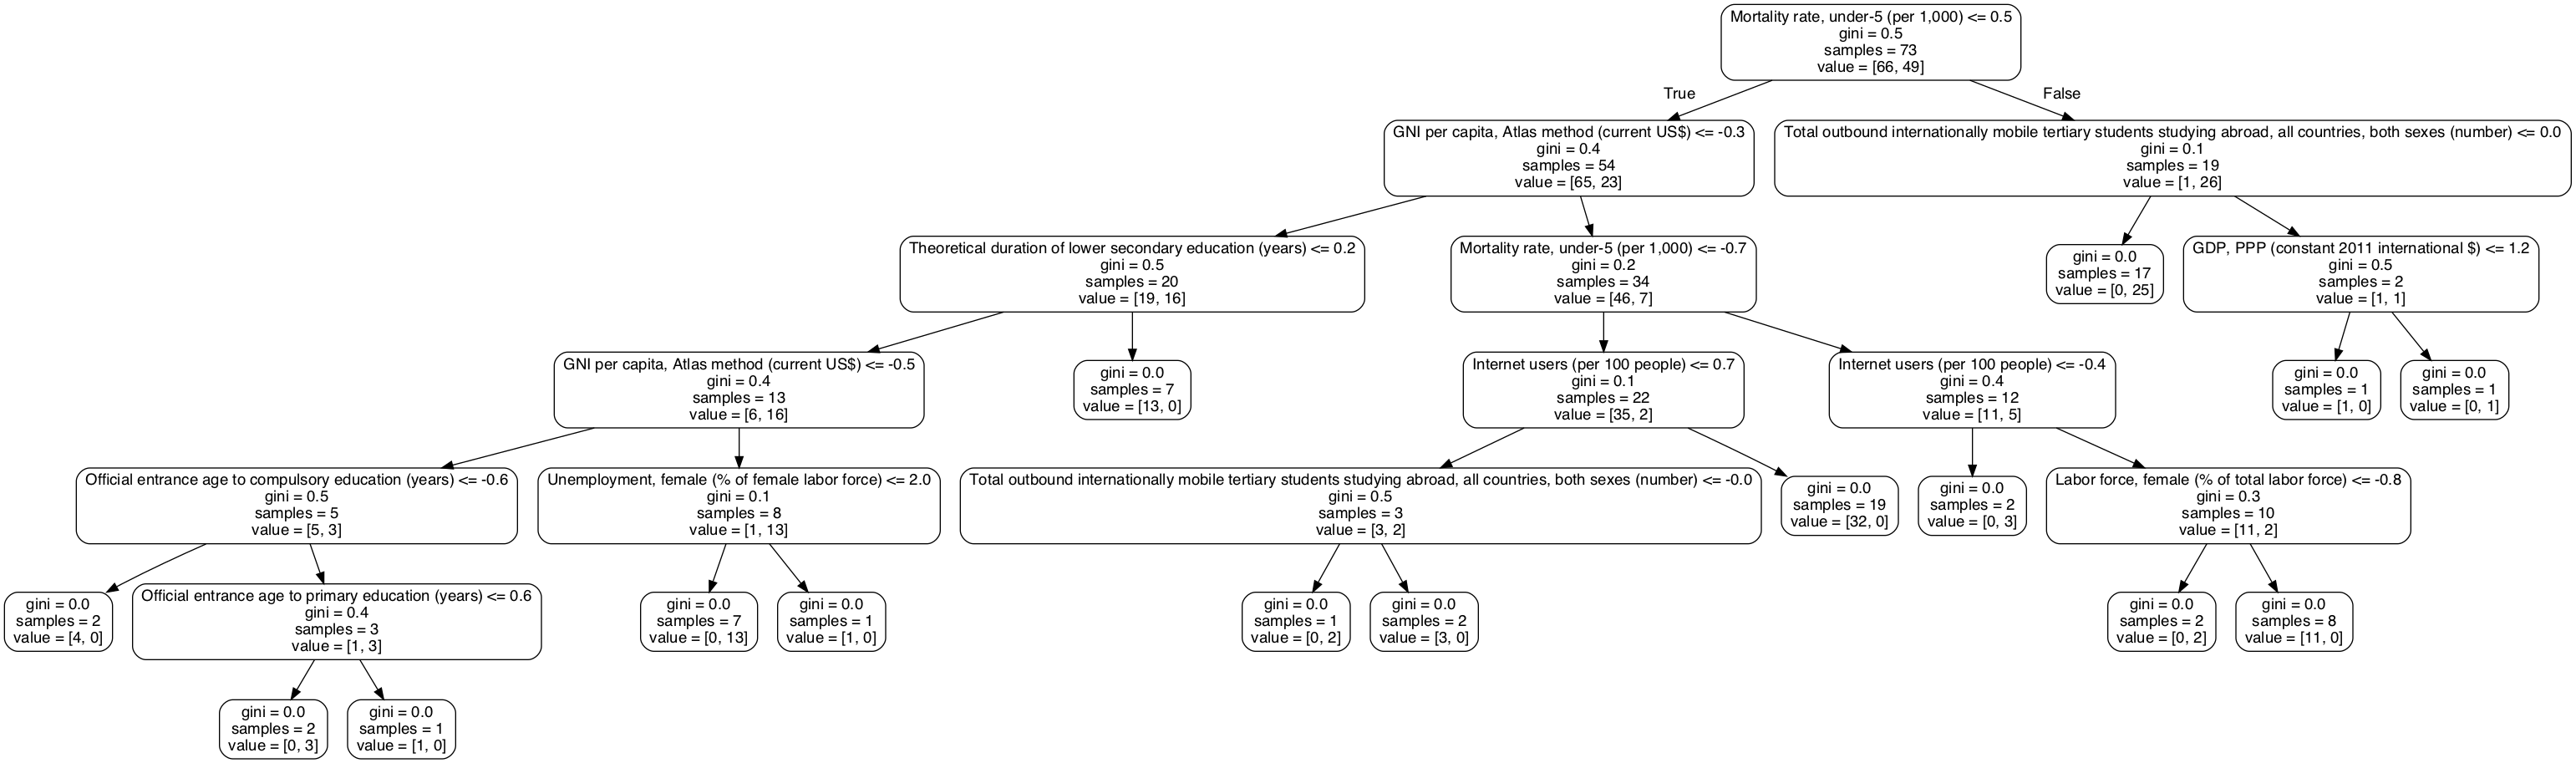

In [66]:
tree = rf.estimators_[5]

export_graphviz(tree, out_file = 'tree.dot', feature_names = features, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
Image(filename = 'tree.png')

Top 5 important features selected by the model and their importance based on mean decrease impurity.

In [67]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances[:5]

[('Internet users (per 100 people)', 0.12),
 ('Mortality rate, under-5 (per 1,000)', 0.11),
 ('Labor force, female (% of total labor force)', 0.07),
 ('GNI per capita, Atlas method (current US$)', 0.06),
 ('GNI per capita, PPP (current international $)', 0.06)]

> As we can see, the number of internect users is the most important feature ranked by the model, followed by mortality rate and % of female in labor force. However, the importances of these features are all below 0.15%. 

> Another note here is that GNI per capita by two different methods are both ranked the fourth most important feature with the same importance. These two indicators are dependent on each other. In random forest models, when the dataset has two or more correlated features, [only one of them will be used as the important predictor](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/). In our dataset, GNI seems to be an important feature, and it could potentially be more important that the percentage of internet users. 

---
## IV. Conclusion and Summary of Results

The World Bank International Education dataset hosted by Google BigQuery is about 600MB, containing over 3600 indicators and over 5 million datapoints (rows). It contains key statistics about global education, including attainment, expenditures and learning outcomes. This report analyzes and visualizes the dataset with the main objective to explore a diverse set of modern data acqusition, management, processing, visualization, and modelling tools and apply the appropriate methods on a real world dataset. A wide varity of methods is implemented in this report, including geographical visualization with basemap, animated graphs with plotly, interactive graphs with ipywidgets, SQL queries, webscrapping with request and BeautifulSoup, modeling with random forest, and so on. 

The following is a summary of results:
- **Attainment**
    1. uneducation rate decreases gloablly and gradually from 1970 to 2010. The world average decreases from about 39% in 1970 to about 15% in 2010.
    - North American countries have the lowest uneducation rate throughout the period.
    - Middle East & North Africa has the highest decreaing rate.
    - South Asia surpasses Sub-Saharan Africa between 2000 and 2005.
    - High income OECD countries have the lowest uneducation rates.
    - High income non OECD countries have similar uneducation rate as upper middle income countries.
    - On average, uneducation rate in low income countries is about 50% higher than high income OECD countries. 
    - As shown in the colorpleth map, some countries in the Africa continent have the lowest uneducation rate above age 15 in 2010. 
    - As shown in the horizontal bar charts, the top five countries that have the highest uneducation rate are from Sub-Saharan Africa, and 8 out of the top 10 are from the region, with Mali having the lowest rate of 74.6%. However, within Africa, we also see low uneducation rate in various countries, like Zimbabwe (5.1%) and South Africa (5.38%). This makes a difference of 69.5%, demonstrating the severity of education attainment disparity in Africa.
    - Europe, North America, and Latin America seem to have really low uneducation rates. In fact, Lithuania, Finland and the Netherlands all have zero uneducation rate. Belize has the lowest uneducation rate in Latin America and it is lower than any countries from continents other than Europe. 
    - West of South Asia also has high uneducation rate, with Afghanistan having the lowest rate of 58.38%. 
    
    
- **Economics and Edcuation**
    1. The dynamic graph clearly shows that many Sub-Saharan Africa countries are left behind over the 1970-2010 period. We can also see that education rates vary very much across the region. 
    - Countries in East Asia & Pacific catch up the fastest in education rate, as well as their population sizes.
    - Europe and North America have the highest education rate as well as GDP per Capita over the period. 
    - There seems to be a linear relationship between GDP per Capita and education rate.
    
    
- **Expenditures on Education**
    1. As we can see from the line charts, percentage on primary education varies the most among different country groups. This might be due to the fact that different country groups have different basic education systems. In some countries, primary schooling is heavily subsidized or free for its citizens, whereas in some countries, primary schooling is a personal investment for inidviual family. This might also be due to the fact that some countries only have limited capacity to focus on early schooling but not higher education.
    - All country groups spend the least on tertiary education. This might be because higher education is normally not mandatory nor provided by national governments. Many universities are supported by private funding. This might also be because some countries don't have the financial capacity to fund higher education.
    - Sub-Saharan Africa invests the highest percentage of their government education expenditures on the primary school level, decreases on the secondary level, and further decreases on the tertiary level. This is different than all other regions, which seems to invest more on secondary schools. This might be because countries in Sub-Saharan Africa lack sufficient financial capacity to invest in education after primary schooling. 
    - Europe focuses the least on primary education compared to other regions. The lion share of its education expenditures goes to secondary education. This might be because in many European countries, such as Finland, [children don't start school until they are older](https://www.theguardian.com/education/2016/sep/20/grammar-schools-play-europe-top-education-system-finland-daycare). Daycare and home schooling is more prevalent for children in primary school ages. 
    - Low income countries show a high focus on primary school. They show a similar pattern as the Sub-Saharan African countries. This shows that many Sub-Saharan African countries belong to low income country group, and further validates the explanation that low income countries might lack the financial capacity to support schools above primary school level. 
    - Simiarly, high income countries show a weaker focus on primary schooling but a stronger focus on secondary schooling. This might be because in high income countries, children don't start school until they are older, since their families have the intellecture capacity to home school or the finanical ability to provide high quality daycare and private teachers. At the same time, universities attract more private funding from successful alumi.
    - Even though there is only one country representing North America in our dataset (the US), it actually represents 33% of the region, since there are only three countries grouped into the region. Even though Europe & Central Asia has 15 countries' data available, they only represent 26% of the region, since there are 58 countries in the region.
    - Line charts for both education expenditures at % of GDP and % of total government spending flucturate quite a lot. This might be partially due to the fact that we only have 26 countries' data available. The lines (mean of countries within that country group) would be smoother if we have more data available. 
    - There is a noticeable increase of world average from 2008 to 2009 in % of GDP, but not in % of total government expenditures. This might be because many countries' GDP suffered during the global financial crisis. 
    - For % of GDP, only European and Central Asian and high income OECD countries beat the world's average througout the period. However, it is the opposite if we look at % of total government spending. This interesting result might be because the proportion of government spending of GDP is higher for these countries. That is, if we consider the following as the [formula for GDP](https://courses.lumenlearning.com/boundless-economics/chapter/comparing-real-and-nominal-gdp/): private consumption + gross investment + government investment + government spending + (exports – imports), these countries' government spendings have a higher influence on GDP than the averages of other country groups. 
    

- **Learning Outcomes**:
    1. From the line charts, we can easily divide the country groups into those above the world average and those below: North America, East Asia & Pacific, and Europe & Central Asia are consistently above the world average for all three subjects, while Middle East & North Africa and Latin America & Caribbean are consistenty below the world average. Similarly, high income OECD and non OECD countries are consistently above the world average, while upper middle income and lower middle income countries score are below the world average for all three subjects.
    - North American countries outperform the rest of the world in reading and science throughout the period, and math until 2010 when East Asian students surpass their peers in North America. High income OECD countries maintain their best scores for all subject throughout from 2003 to 2015. 
    - Countries in Middle East & North Africa and lower middle income countries show large fluctuations of performances throughout the period. Middle Eastern & North Afrian countries first experience a drastic drop from 2000 to 2003 and gradually increase from 2003 to 2009. Lower middle income countries have their lowest performance in 2006 for all subjects and drastically increase over the years until 2012 when all scores drop again.
    - The world average of all three subjects shows a decreasing trend at the end of 2015. This should alarm teachers and educators worldwide. It is important to identify the reasons behind the drop of learning outcomes. However, it is also important to note that scores are not the only indicator for educational quality and learning outcomes. Students might have been building capacity in other important areas, such as creative thinking and programming, without improving their test scores in traditional subjects like reading, science and math. 
    - Europe & Central Asia, East Asia & Pacific, and North America occupies the top 30 for all subjects from 2000 to 2015.
    - Europe & Central Asia has the highest percentage of countries in top 30 for all subjects from 2000 to 2015. 
    - East Asia & Pacific has the highest percentage of countries in top 10 for math and science from 2000 to 2015.
    - However, as we see from the stacked bar chats, even though Europe outperforms East Asia and North America with the number of countries in the top 30 countries. It underperforms when we look at the percentage of European countries in the top 30.
    
    
- **Modelling**:
    1. Using data from 2010 and percentage of population above age 15 with no education, random forest classifier indentifies the number of internect users as the most important feature, followed by mortality rate and % of female in labor force. However, the importances of these features are all below 0.15% and it only chooses from 33 predictive features.
    - The model achieves 76% of accuracy rate.


---
## V. Discussion
This report has many limitations. 
First of all, it is limited by the lack of data availability for many indicators. Even with selected indicators, the final data used for visualization only represents a small part of the world. To get a better understanding of key education statistics, it is important to inrease statistical capacity in all countries. Secondly, it is important to note that the results might overestimate many indicators in the dataset, because the countries that have data available tend to have high statisticals capacity, which is correlated with the country's financial abililty and political stability. 

---
## VI. Future Work
There are many ways to improve this report. Here is a list of some potential directions:
1. further breakdown of available indicators by age and gender;
2. utilize clustering methods to generate different country groupings than just by region or income group;
3. compare performance of different machine learning models on the dataset.